## Finetune Demo

### Imports

In [11]:
from imports import *

In [12]:
# overall imports
import importlib
import data

# data load
from data.data_load import load_transcriptome, load_connectome
importlib.reload(data.data_load)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import cv_split.cv_split
from cv_split.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(cv_split.cv_split)

# prebuilt model classes
import models.prebuilt_models
from models.prebuilt_models import ModelBuild
importlib.reload(models.prebuilt_models)

# metric classes
import metrics.distance_FC
import metrics.eval
from metrics.eval import ModelEvaluator
from metrics.eval import pearson_numpy, mse_numpy, r2_numpy, pearson_cupy, mse_cupy, r2_cupy
importlib.reload(metrics.eval)

# sim class
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
import sim.multi_sim_run
from sim.sim import Simulation
from sim.multi_sim_run import multi_sim_run, single_sim_run, open_pickled_results, combine_results
importlib.reload(sim.sim)
importlib.reload(sim.sim_utils)
importlib.reload(sim.multi_sim_run)

# plot
import sim.plot
from sim.plot import (
    plot_predictions, 
    barplot_model_performance,
    boxplot_model_performance,
    plot_predictions_with_metrics, plot_single_model_predictions_with_metrics,
    plot_best_params_table, plot_best_parameters_table_colored, 
    violin_plot_model_performance
)

importlib.reload(sim.plot)

<module 'sim.plot' from '/scratch/asr655/neuroinformatics/Gene2Conn/sim/plot.py'>

#### Check job specs

In [13]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 0.0%
RAM Usage: 5.1%
Available RAM: 357.4G
Total RAM: 376.8G
52.4G


In [14]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

XGBoost version: 2.0.3
cupy version: 13.1.0


In [15]:
GPUtil.getAvailable()
# if a number is seen a GPU is available

[]

In [16]:
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

RuntimeError: Could not find an available GPU after 1 attempts with 900 seconds interval.

In [17]:
GPUtil.showUtilization()


| ID | GPU | MEM |
------------------


In [ ]:
torch.cuda.is_available()


In [ ]:

def save_sims_finetune(multi_model_results, feature_type, cv_type, model_type, use_shared_regions, test_shared_regions, resolution): 
    """
    Function to save all sim results to a pickle file
    """

    sim_results_file_path = os.getcwd() + '/sim_results/'
    
    if feature_type == "all":
        results_file_str = "multi_sim_" + cv_type + "_" + model_type
    elif feature_type == "conn only":
        results_file_str = "single_sim_conn_" + cv_type + "_" + model_type
    elif feature_type == "trans only":
        results_file_str = "finetune_single_sim_trans_" + cv_type + "_" + model_type
    elif feature_type == "trans plus conn":
        results_file_str = "single_sim_transplusconn_" + cv_type + "_" + model_type

    
    if cv_type == "community": 
        results_file_str += str(resolution)
        
    if use_shared_regions: 
        results_file_str += "_useshared"
        if test_shared_regions: 
            results_file_str += "_testshared"
        else: 
            results_file_str += "_trainshared"        

    results_file_path = os.path.join(sim_results_file_path, results_file_str)
    results_file_path_pickle = results_file_path + '.pickle'
    
    # Save the list to a file using pickle
    with open(results_file_path_pickle, 'wb') as f:
        pickle.dump(multi_model_results, f)
    
    print("Multi simulation results have been saved.")
    return

## Table of Contents
- [PLS Sims](#PLS-Sims)
  - [Random Splits](#PLS-Random-Splits)
  - [Community Splits](#PLS-Community-Splits)
  - [Schaefer Splits](#PLS-Schaefer-Splits)
- [Ridge Sims](#Ridge-Sims)
  - [Random Splits](#Ridge-Random-Splits)
  - [Community Splits](#Ridge-Community-Splits)
  - [Schaefer Splits](#Ridge-Schaefer-Splits)
- [XGBoost Sims](#XGBoost-Sims)
  - [Random Splits](#Ridge-Random-Splits)
  - [Community Splits](#Ridge-Community-Splits)
  - [Schaefer Splits](#Ridge-Schaefer-Splits)

#### Simulation tests <a id="sims"></a>

### XGBoost <a id="XGBoost-Sims"></a>

#### 4-fold Community split

Community split, train on shared

Run on individual best hyperparams (make sure to change grids between)

In [26]:
conn_xgb_community_shared_sim_results = single_sim_run(
                                              'conn only',
                                              'community',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=True, 
                                              test_shared_regions=False, 
                                              resolution=1.02)

'''
best_params = {
            'n_estimators': [250],
            'max_depth': [5],           # Maximum depth of each tree - makes a big diff
            'learning_rate': [0.3],     # Learning rate (shrinkage)
            'subsample': [1],              # Subsample ratio of the training data
            'colsample_bytree': [1],  # Subsample ratio of columns when constructing each tree
            'gamma': [0],             # Minimum loss reduction required to make a split
            'reg_lambda': [.1],              # L2 regularization term (Ridge penalty)
            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)
            'random_state': [42],        # Seed for reproducibility
            'min_child_weight': [3], 
            'tree_method':['hist'],  # Use the GPU
            'device':['cuda'],  # Use GPU predictor
            'verbosity': [2]
        }
'''
# DONE


 Test fold num: 1
(12540, 190) (12540,) (342, 190) (342,)
2
3
4
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=0.1, subsample=1, tree_method=hist, verbosity=2; total time=   0.3s

Grid Search CV Results:
Best Cross-Validation Score:  0.8715708337756596
Best Parameters:  {'colsample_bytree': 1, 'device': 'cuda', 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'subsample': 1, 'tree_method': 'hist', 'verbosity': 2}
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=0.1, subsample=1, tree_method=hist, verbosity=2; total time=   0.3s

Grid Sear

"\nbest_params = {\n            'n_estimators': [250],\n            'max_depth': [5],           # Maximum depth of each tree - makes a big diff\n            'learning_rate': [0.3],     # Learning rate (shrinkage)\n            'subsample': [1],              # Subsample ratio of the training data\n            'colsample_bytree': [1],  # Subsample ratio of columns when constructing each tree\n            'gamma': [0],             # Minimum loss reduction required to make a split\n            'reg_lambda': [.1],              # L2 regularization term (Ridge penalty)\n            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)\n            'random_state': [42],        # Seed for reproducibility\n            'min_child_weight': [3], \n            'tree_method':['hist'],  # Use the GPU\n            'device':['cuda'],  # Use GPU predictor\n            'verbosity': [2]\n        }\n"

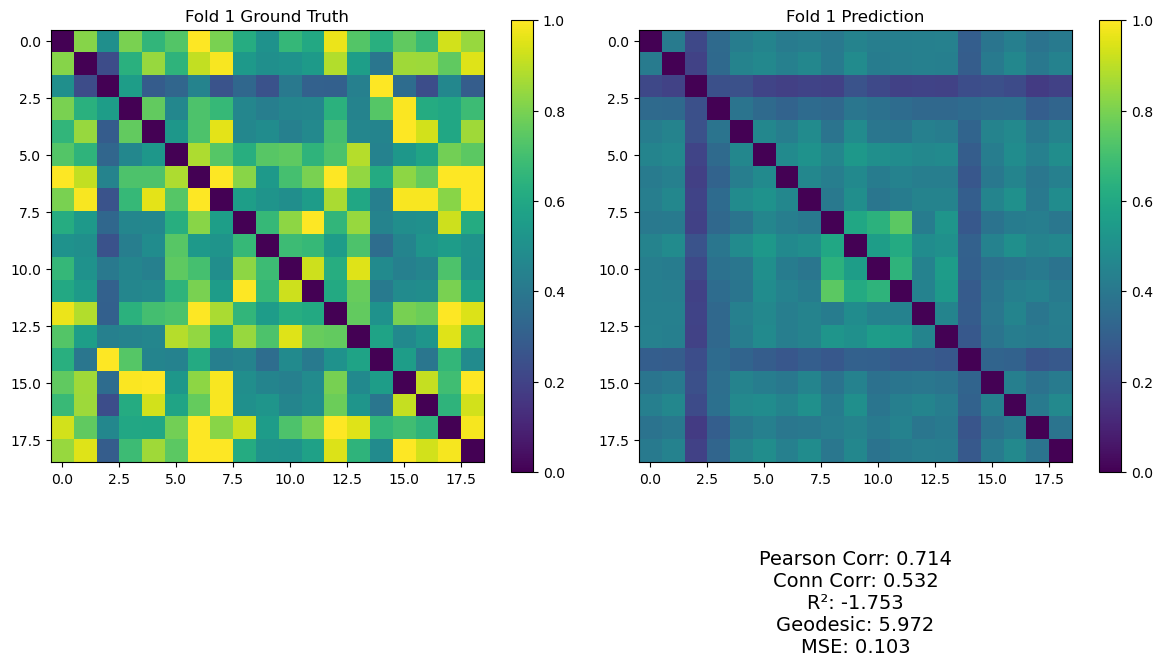

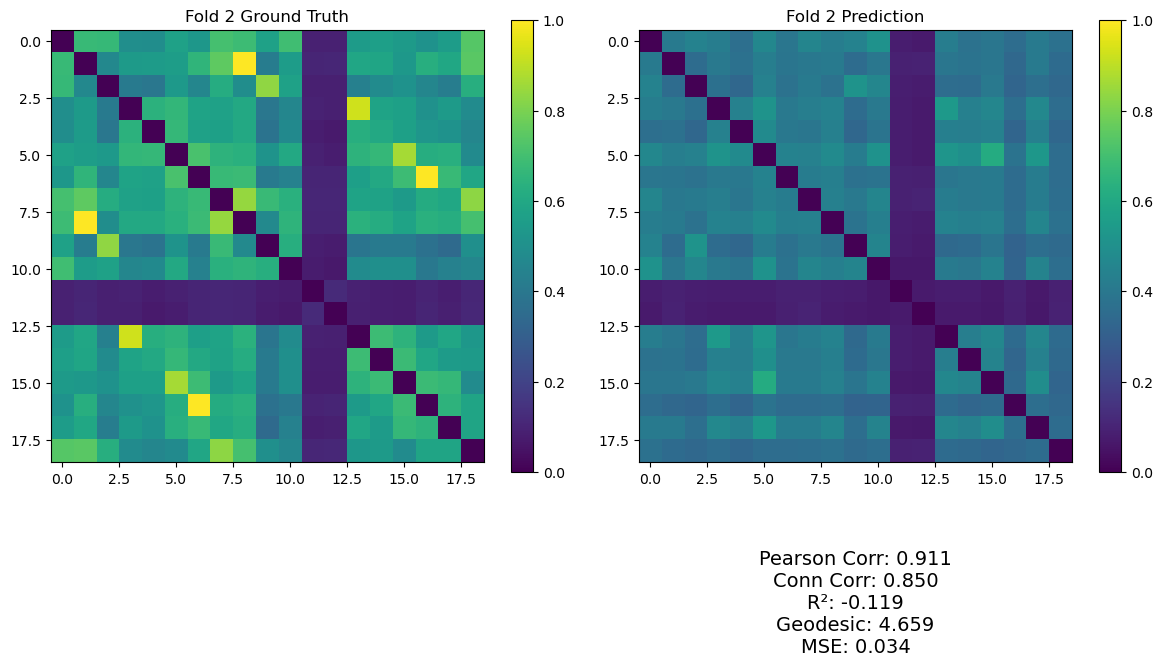

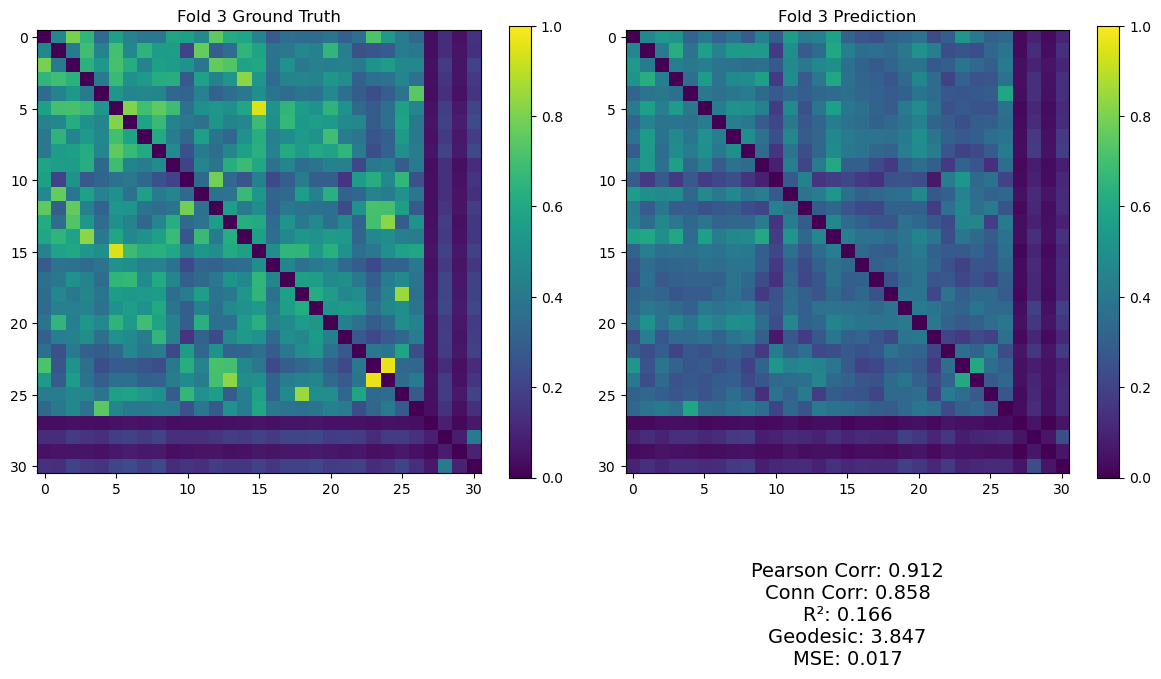

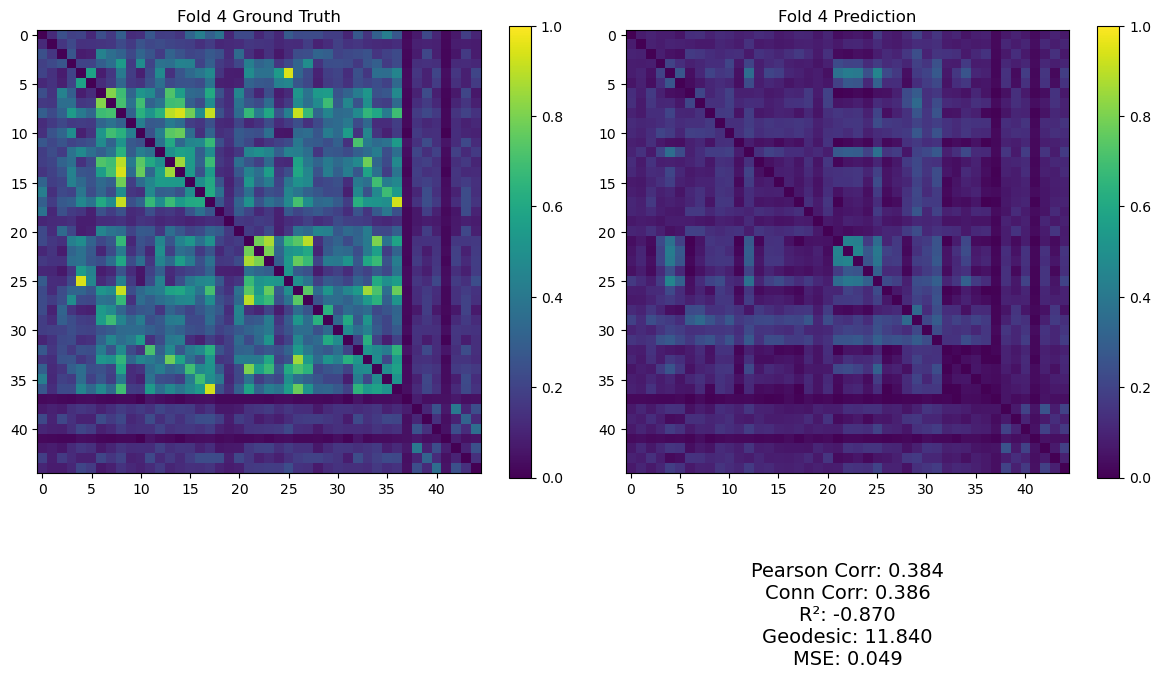

In [41]:
plot_single_model_predictions_with_metrics(conn_xgb_community_shared_sim_results)

In [11]:
print(conn_xgb_community_shared_sim_results)

[[{'model_parameters': {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.3, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': 2}, 'train_metrics': {'mse': 0.0001339804023255208, 'mae': 0.008667577137875658, 'r2': 0.995188404

In [30]:
trans_xgb_community_shared_sim_results = single_sim_run(
                                              'trans only',
                                              'community',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=True, 
                                              test_shared_regions=False, 
                                              resolution=1.02)
'''
best_params = {
            'n_estimators': [200],
            'max_depth': [7],           # Maximum depth of each tree - makes a big diff
            'learning_rate': [0.1],     # Learning rate (shrinkage)
            'subsample': [1],              # Subsample ratio of the training data
            'colsample_bytree': [1],  # Subsample ratio of columns when constructing each tree
            'gamma': [0],             # Minimum loss reduction required to make a split
            'reg_lambda': [1],              # L2 regularization term (Ridge penalty)
            'reg_alpha': [0.1],             # L1 regularization term (Lasso penalty)
            'random_state': [42],        # Seed for reproducibility
            'min_child_weight': [3], 
            'tree_method':['hist'],  # Use the GPU
            'device':['cuda'],  # Use GPU predictor
            'verbosity': [2]
        }
'''
# DONE

Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(12540, 22106) (12540,) (342, 22106) (342,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200, random_state=42, reg_alpha=0.1, reg_lambda=1, subsample=1, tree_method=hist, verbosity=2; total time=   5.9s
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200, random_state=42, reg_alpha=0.1, reg_lambda=1, subsample=1, tree_method=hist, verbosity=2; total time=   5.8s
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200, random_state=42, reg_alpha=0.1, reg_lambda=1, subsample=1, tree_method=hist, verbosity=2; total time=   5.5s

Grid Search CV Results:
Best Param

"\nbest_params = {\n            'n_estimators': [200],\n            'max_depth': [7],           # Maximum depth of each tree - makes a big diff\n            'learning_rate': [0.1],     # Learning rate (shrinkage)\n            'subsample': [1],              # Subsample ratio of the training data\n            'colsample_bytree': [1],  # Subsample ratio of columns when constructing each tree\n            'gamma': [0],             # Minimum loss reduction required to make a split\n            'reg_lambda': [1],              # L2 regularization term (Ridge penalty)\n            'reg_alpha': [0.1],             # L1 regularization term (Lasso penalty)\n            'random_state': [42],        # Seed for reproducibility\n            'min_child_weight': [3], \n            'tree_method':['hist'],  # Use the GPU\n            'device':['cuda'],  # Use GPU predictor\n            'verbosity': [2]\n        }\n"

In [93]:
save_sims_finetune(trans_xgb_community_shared_sim_results, 'trans only', 'community', 'xgboost', True, False, 1.02)

Multi simulation results have been saved.


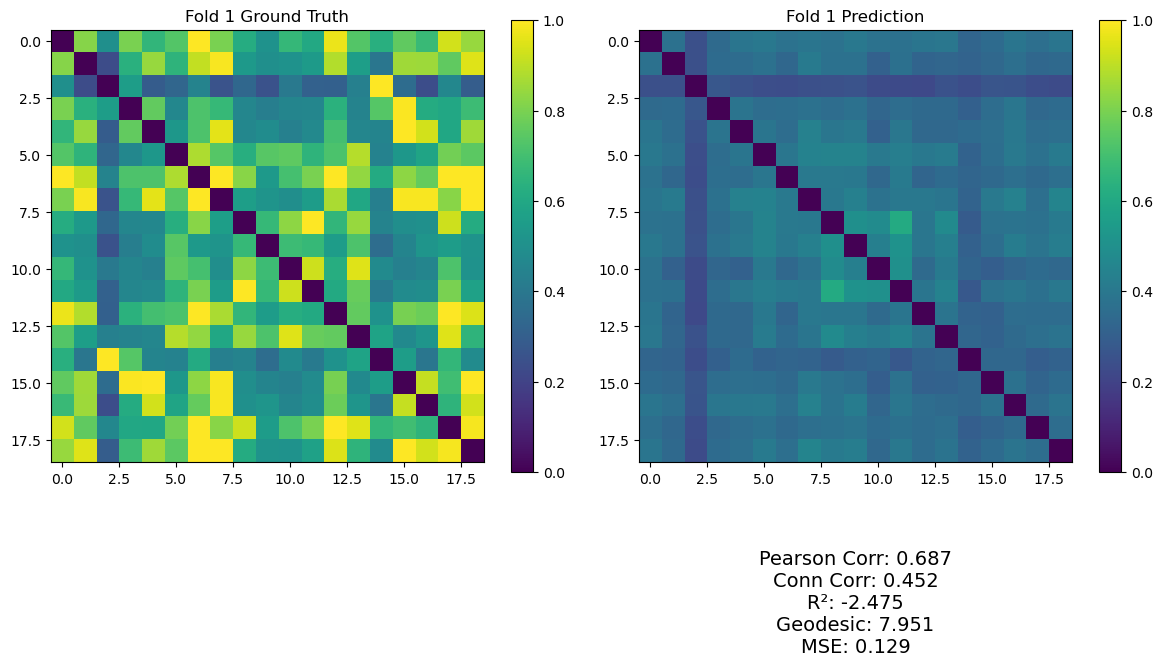

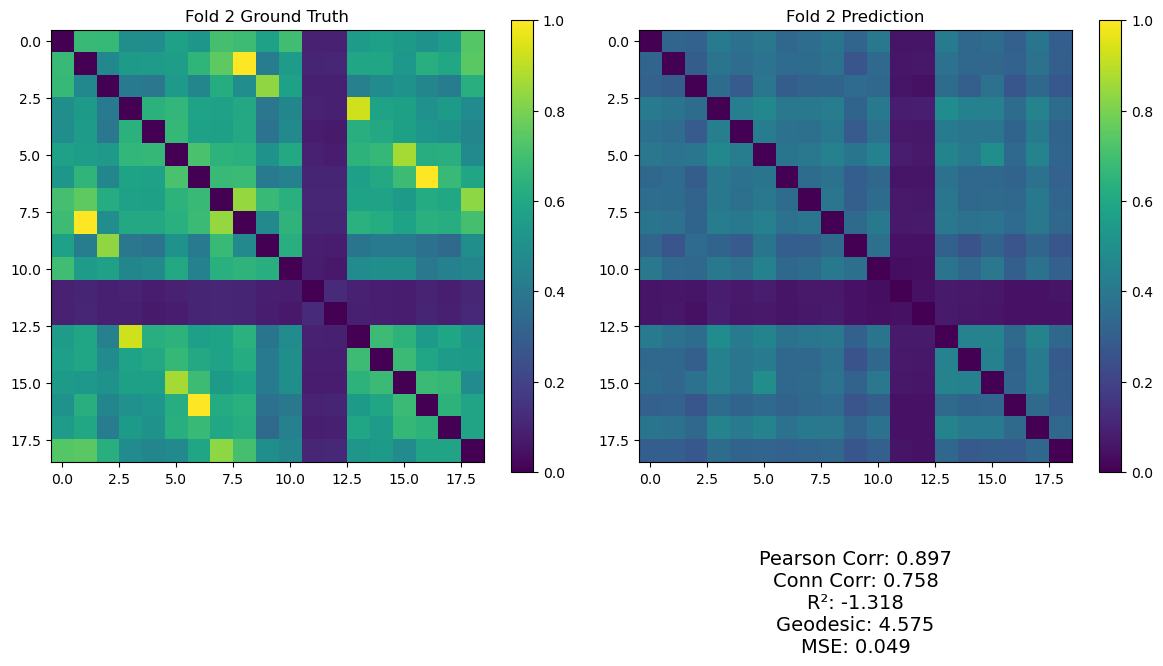

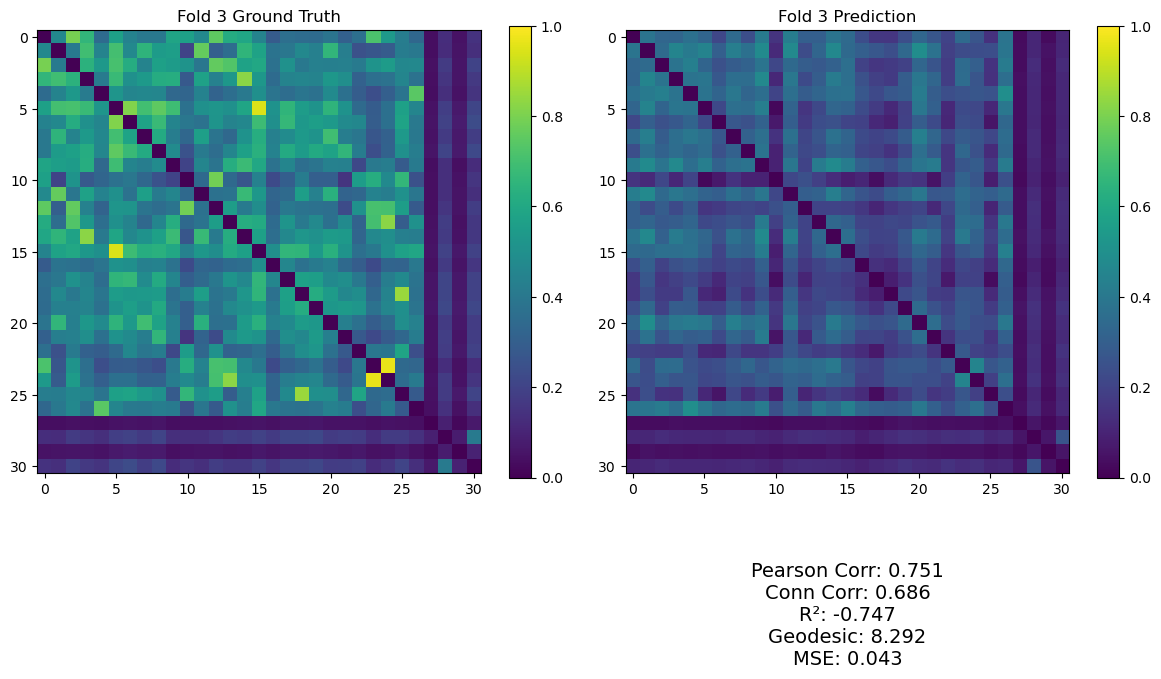

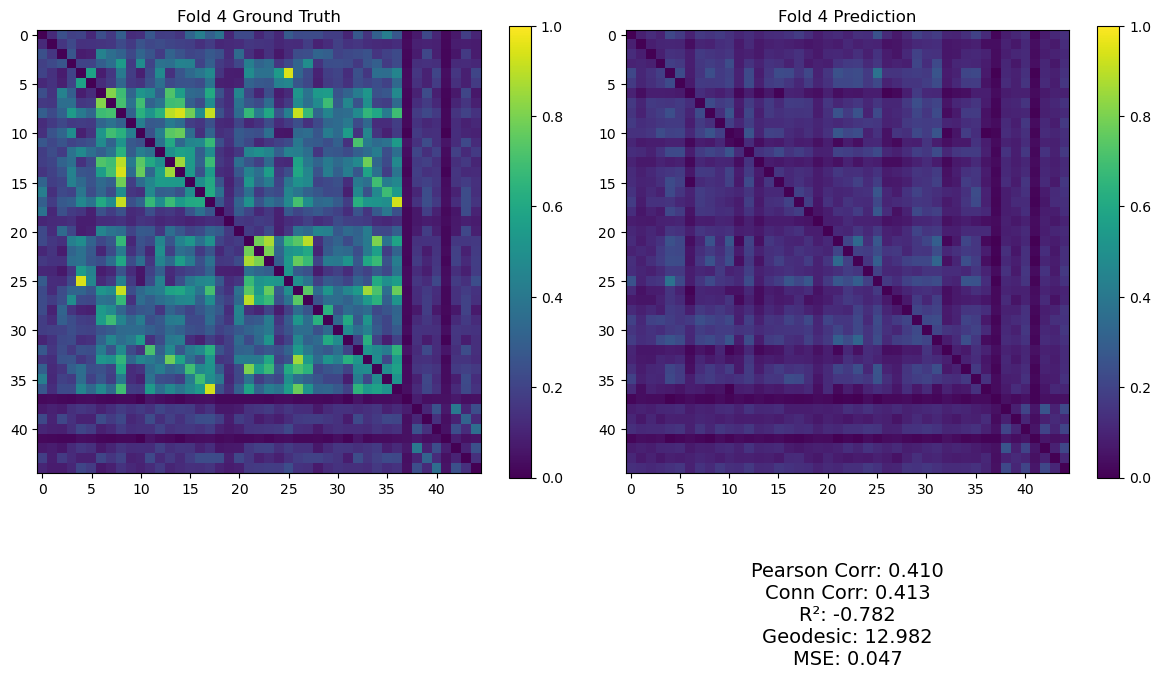

In [42]:
plot_single_model_predictions_with_metrics(trans_xgb_community_shared_sim_results)

In [38]:
transconn_xgb_community_shared_sim_results = single_sim_run(
                                              'trans plus conn',
                                              'community',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=True, 
                                              test_shared_regions=False,
                                              resolution=1.02)

'''
best_params = {
            'n_estimators': [250],
            'max_depth': [5],           # Maximum depth of each tree - makes a big diff
            'learning_rate': [0.1],     # Learning rate (shrinkage)
            'subsample': [1],              # Subsample ratio of the training data
            'colsample_bytree': [1],  # Subsample ratio of columns when constructing each tree
            'gamma': [0],             # Minimum loss reduction required to make a split
            'reg_lambda': [.1],              # L2 regularization term (Ridge penalty)
            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)
            'random_state': [42],        # Seed for reproducibility
            'min_child_weight': [3], 
            'tree_method':['hist'],  # Use the GPU
            'device':['cuda'],  # Use GPU predictor
            'verbosity': [2]
        }
'''
# DONE

Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(12540, 22296) (12540,) (342, 22296) (342,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=0.1, subsample=1, tree_method=hist, verbosity=2; total time=   3.5s

Grid Search CV Results:
Best Cross-Validation Score:  0.8643786323252304
Best Parameters:  {'colsample_bytree': 1, 'device': 'cuda', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'subsample': 1, 'tree_method': 'hist', 'verbosity': 2}
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.1, max_depth=5, min_child

"\nbest_params = {\n            'n_estimators': [250],\n            'max_depth': [5],           # Maximum depth of each tree - makes a big diff\n            'learning_rate': [0.1],     # Learning rate (shrinkage)\n            'subsample': [1],              # Subsample ratio of the training data\n            'colsample_bytree': [1],  # Subsample ratio of columns when constructing each tree\n            'gamma': [0],             # Minimum loss reduction required to make a split\n            'reg_lambda': [.1],              # L2 regularization term (Ridge penalty)\n            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)\n            'random_state': [42],        # Seed for reproducibility\n            'min_child_weight': [3], \n            'tree_method':['hist'],  # Use the GPU\n            'device':['cuda'],  # Use GPU predictor\n            'verbosity': [2]\n        }\n"

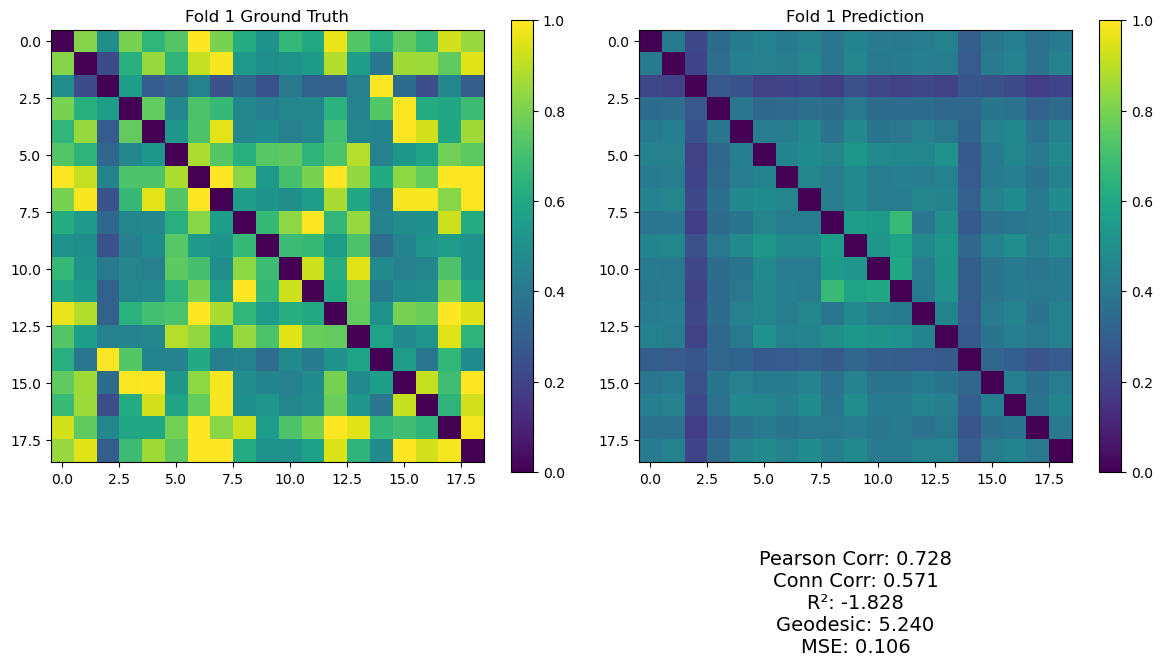

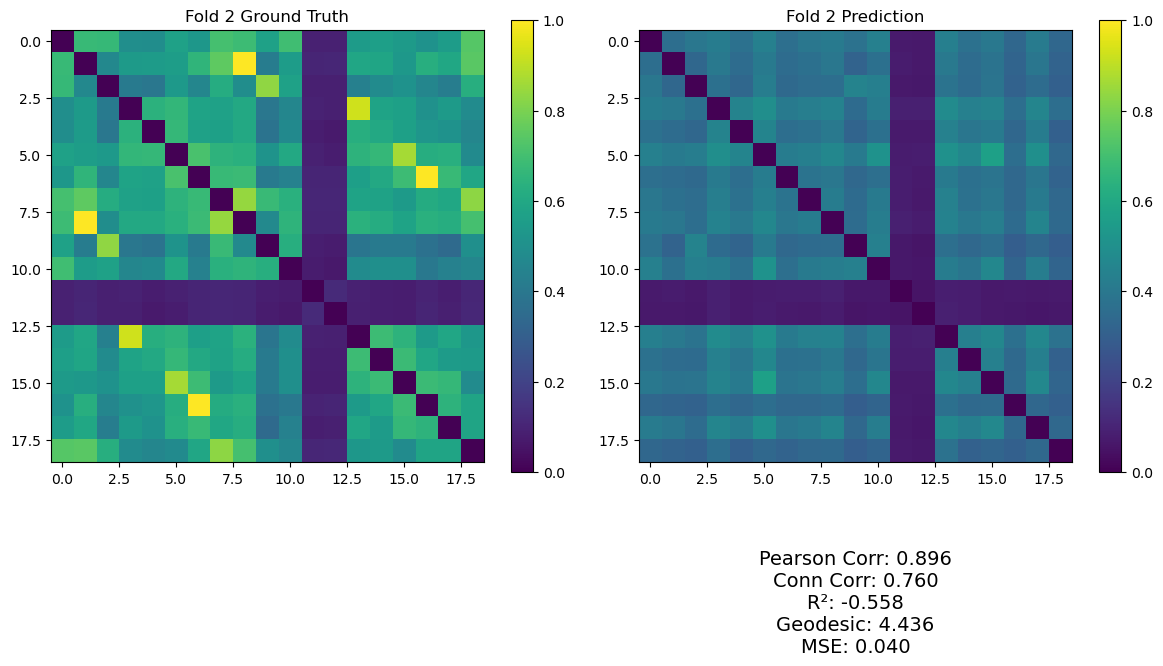

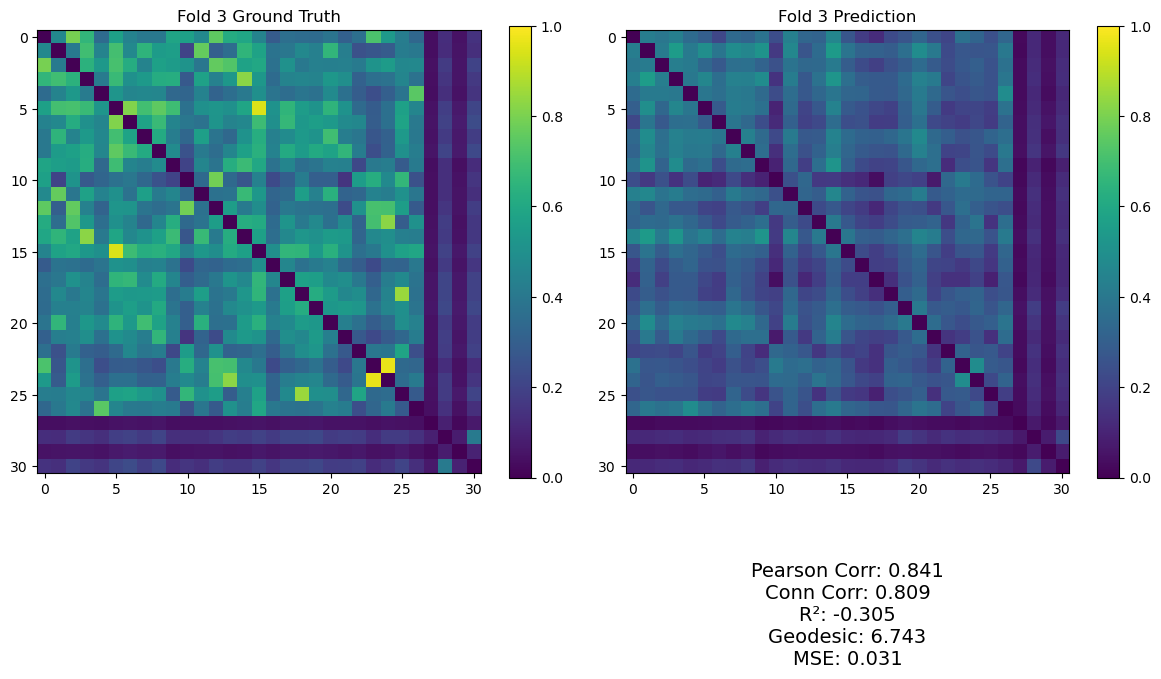

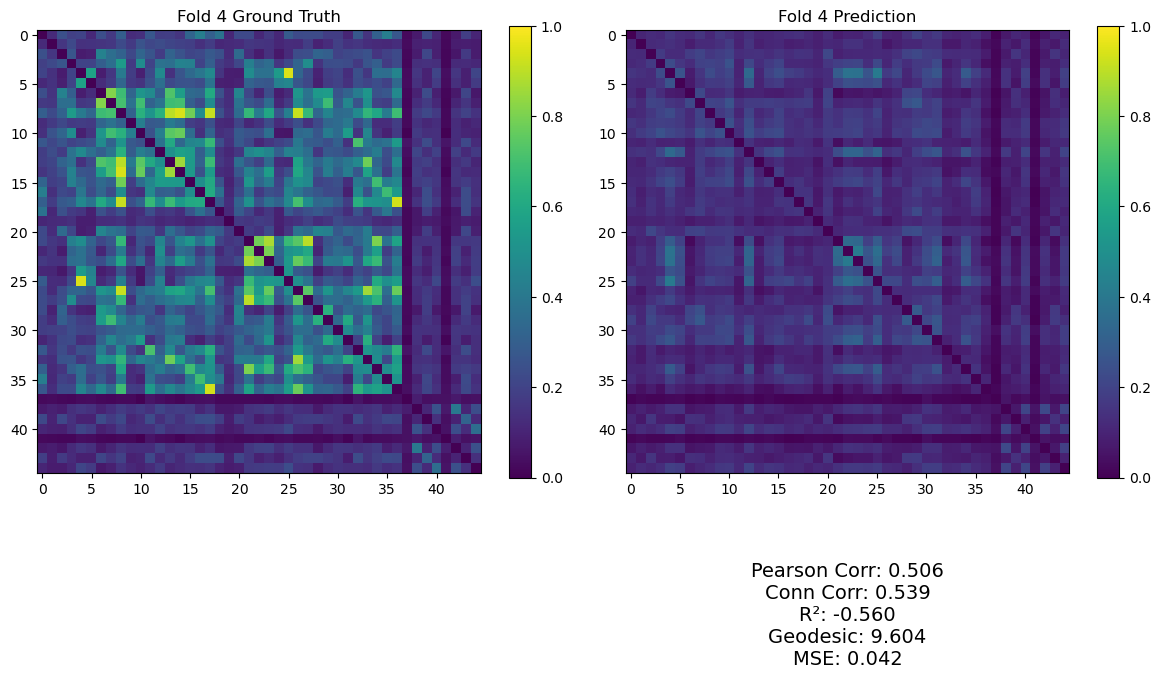

In [43]:
plot_single_model_predictions_with_metrics(transconn_xgb_community_shared_sim_results)

Community split, test on shared

In [48]:
conn_xgb_community_testshared_sim_results = single_sim_run(
                                              'conn only',
                                              'community',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=True, 
                                              test_shared_regions=True, 
                                              resolution=1.02)

'''
best_params = {
            'n_estimators': [250],
            'max_depth': [3],           # Maximum depth of each tree - makes a big diff
            'learning_rate': [0.3],     # Learning rate (shrinkage)
            'subsample': [1],              # Subsample ratio of the training data
            'colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree
            'gamma': [0],             # Minimum loss reduction required to make a split
            'reg_lambda': [1],              # L2 regularization term (Ridge penalty)
            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)
            'random_state': [42],        # Seed for reproducibility
            'min_child_weight': [1], 
            'tree_method':['hist'],  # Use the GPU
            'device':['cuda'],  # Use GPU predictor
            'verbosity': [2]
        }
'''
# DONE


 Test fold num: 1
(8930, 190) (8930,) (3952, 190) (3952,)
2
3
4
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=0.8, device=cuda, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=1, subsample=1, tree_method=hist, verbosity=2; total time=   0.2s

Grid Search CV Results:
Best Cross-Validation Score:  0.8566376444903969
Best Parameters:  {'colsample_bytree': 0.8, 'device': 'cuda', 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 1, 'tree_method': 'hist', 'verbosity': 2}
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=0.8, device=cuda, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=1, subsample=1, tree_method=hist, verbosity=2; total time=   0.2s

Grid Sear

"\nbest_params = {\n            'n_estimators': [250],\n            'max_depth': [3],           # Maximum depth of each tree - makes a big diff\n            'learning_rate': [0.3],     # Learning rate (shrinkage)\n            'subsample': [1],              # Subsample ratio of the training data\n            'colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree\n            'gamma': [0],             # Minimum loss reduction required to make a split\n            'reg_lambda': [1],              # L2 regularization term (Ridge penalty)\n            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)\n            'random_state': [42],        # Seed for reproducibility\n            'min_child_weight': [1], \n            'tree_method':['hist'],  # Use the GPU\n            'device':['cuda'],  # Use GPU predictor\n            'verbosity': [2]\n        }\n"

ValueError: Unknown format code 'f' for object of type 'str'

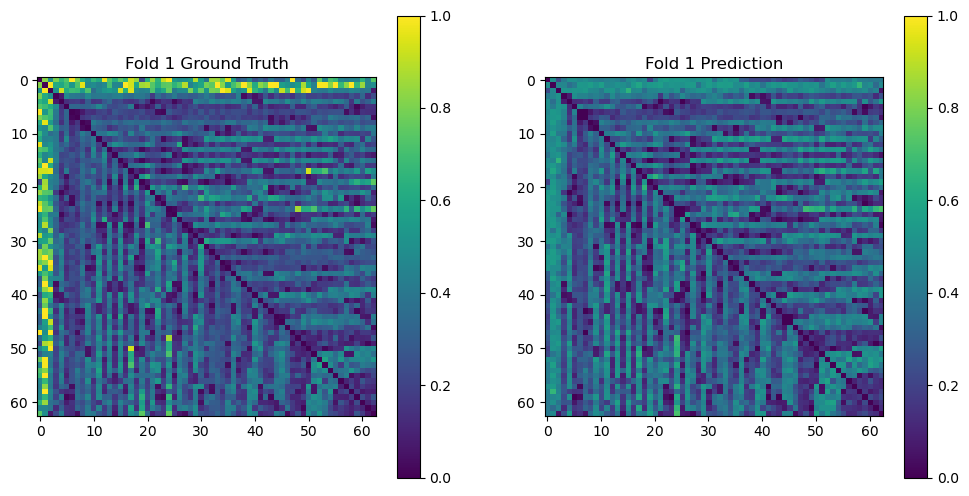

In [50]:
plot_single_model_predictions_with_metrics(conn_xgb_community_testshared_sim_results)

In [52]:
trans_xgb_community_testshared_sim_results = single_sim_run(
                                              'trans only',
                                              'community',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=True, 
                                              test_shared_regions=False, 
                                              resolution=1.02)
'''
# NOT THE BEST SEE WIDER RANGE
best_params = {
            'n_estimators': [150],
            'max_depth': [3],           # Maximum depth of each tree - makes a big diff
            'learning_rate': [0.1],     # Learning rate (shrinkage)
            'subsample': [1],              # Subsample ratio of the training data
            'colsample_bytree': [0.5],  # Subsample ratio of columns when constructing each tree
            'gamma': [0],             # Minimum loss reduction required to make a split
            'reg_lambda': [.1],              # L2 regularization term (Ridge penalty)
            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)
            'random_state': [42],        # Seed for reproducibility
            'min_child_weight': [1], 
            'tree_method':['hist'],  # Use the GPU
            'device':['cuda'],  # Use GPU predictor
            'verbosity': [2]
        }
'''
# DONE

Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(12540, 22106) (12540,) (342, 22106) (342,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.5, device=cuda, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=150, random_state=42, reg_alpha=0.01, reg_lambda=0.1, subsample=1, tree_method=hist, verbosity=2; total time=   1.4s
[CV] END colsample_bytree=0.5, device=cuda, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=150, random_state=42, reg_alpha=0.01, reg_lambda=0.1, subsample=1, tree_method=hist, verbosity=2; total time=   1.2s
[CV] END colsample_bytree=0.5, device=cuda, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=150, random_state=42, reg_alpha=0.01, reg_lambda=0.1, subsample=1, tree_method=hist, verbosity=2; total time=   1.1s

Grid Search CV Resu

"\nbest_params = {\n            'n_estimators': [150],\n            'max_depth': [3],           # Maximum depth of each tree - makes a big diff\n            'learning_rate': [0.1],     # Learning rate (shrinkage)\n            'subsample': [1],              # Subsample ratio of the training data\n            'colsample_bytree': [0.5],  # Subsample ratio of columns when constructing each tree\n            'gamma': [0],             # Minimum loss reduction required to make a split\n            'reg_lambda': [.1],              # L2 regularization term (Ridge penalty)\n            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)\n            'random_state': [42],        # Seed for reproducibility\n            'min_child_weight': [1], \n            'tree_method':['hist'],  # Use the GPU\n            'device':['cuda'],  # Use GPU predictor\n            'verbosity': [2]\n        }\n"

In [94]:
save_sims_finetune(trans_xgb_community_testshared_sim_results, 'trans only', 'community', 'xgboost', True, True, 1.02)

Multi simulation results have been saved.


In [ ]:
plot_single_model_predictions_with_metrics(trans_xgb_community_testshared_sim_results)

In [54]:
transconn_xgb_community_testshared_sim_results = single_sim_run(
                                              'trans plus conn',
                                              'community',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=True, 
                                              test_shared_regions=True,
                                              resolution=1.02)

'''
best_params = {
            'n_estimators': [250],
            'max_depth': [3],           # Maximum depth of each tree - makes a big diff
            'learning_rate': [0.1],     # Learning rate (shrinkage)
            'subsample': [1],              # Subsample ratio of the training data
            'colsample_bytree': [1],  # Subsample ratio of columns when constructing each tree
            'gamma': [0],             # Minimum loss reduction required to make a split
            'reg_lambda': [.01],              # L2 regularization term (Ridge penalty)
            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)
            'random_state': [42],        # Seed for reproducibility
            'min_child_weight': [3], 
            'tree_method':['hist'],  # Use the GPU
            'device':['cuda'],  # Use GPU predictor
            'verbosity': [2]
        }
'''
# DONE

Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(8930, 22296) (8930,) (3952, 22296) (3952,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=0.01, subsample=1, tree_method=hist, verbosity=2; total time=   1.5s

Grid Search CV Results:
Best Cross-Validation Score:  0.8277105228754346
Best Parameters:  {'colsample_bytree': 1, 'device': 'cuda', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 1, 'tree_method': 'hist', 'verbosity': 2}
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.1, max_depth=3, min_chi

"\nbest_params = {\n            'n_estimators': [250],\n            'max_depth': [3],           # Maximum depth of each tree - makes a big diff\n            'learning_rate': [0.1],     # Learning rate (shrinkage)\n            'subsample': [1],              # Subsample ratio of the training data\n            'colsample_bytree': [1],  # Subsample ratio of columns when constructing each tree\n            'gamma': [0],             # Minimum loss reduction required to make a split\n            'reg_lambda': [.01],              # L2 regularization term (Ridge penalty)\n            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)\n            'random_state': [42],        # Seed for reproducibility\n            'min_child_weight': [3], \n            'tree_method':['hist'],  # Use the GPU\n            'device':['cuda'],  # Use GPU predictor\n            'verbosity': [2]\n        }\n"

In [ ]:
plot_single_model_predictions_with_metrics(transconn_xgb_community_testshared_sim_results)

Community split, test distinct

In [56]:
conn_xgb_community_sim_results = single_sim_run(
                                              'conn only',
                                              'community',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=False, 
                                              test_shared_regions=False, 
                                              resolution=1.02)

'''
best_params = {
            'n_estimators': [100],
            'max_depth': [7],           # Maximum depth of each tree - makes a big diff
            'learning_rate': [0.1],     # Learning rate (shrinkage)
            'subsample': [1],              # Subsample ratio of the training data
            'colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree
            'gamma': [0],             # Minimum loss reduction required to make a split
            'reg_lambda': [1],              # L2 regularization term (Ridge penalty)
            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)
            'random_state': [42],        # Seed for reproducibility
            'min_child_weight': [1], 
            'tree_method':['hist'],  # Use the GPU
            'device':['cuda'],  # Use GPU predictor
            'verbosity': [2]
        }
'''
# DONE


 Test fold num: 1
(8930, 190) (8930,) (342, 190) (342,)
2
3
4
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=0.8, device=cuda, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, random_state=42, reg_alpha=0.01, reg_lambda=1, subsample=1, tree_method=hist, verbosity=2; total time=   0.2s

Grid Search CV Results:
Best Cross-Validation Score:  0.8605497688108731
Best Parameters:  {'colsample_bytree': 0.8, 'device': 'cuda', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 1, 'tree_method': 'hist', 'verbosity': 2}
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=0.8, device=cuda, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, random_state=42, reg_alpha=0.01, reg_lambda=1, subsample=1, tree_method=hist, verbosity=2; total time=   0.2s

Grid Search

"\nbest_params = {\n            'n_estimators': [100],\n            'max_depth': [7],           # Maximum depth of each tree - makes a big diff\n            'learning_rate': [0.1],     # Learning rate (shrinkage)\n            'subsample': [1],              # Subsample ratio of the training data\n            'colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree\n            'gamma': [0],             # Minimum loss reduction required to make a split\n            'reg_lambda': [1],              # L2 regularization term (Ridge penalty)\n            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)\n            'random_state': [42],        # Seed for reproducibility\n            'min_child_weight': [1], \n            'tree_method':['hist'],  # Use the GPU\n            'device':['cuda'],  # Use GPU predictor\n            'verbosity': [2]\n        }\n"

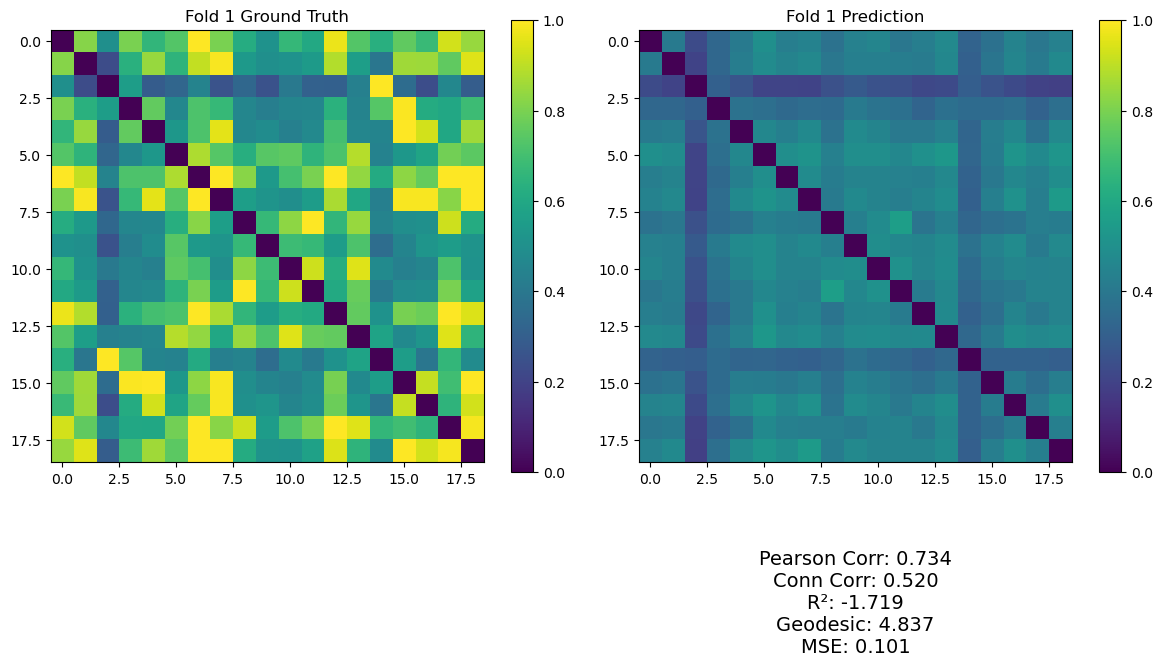

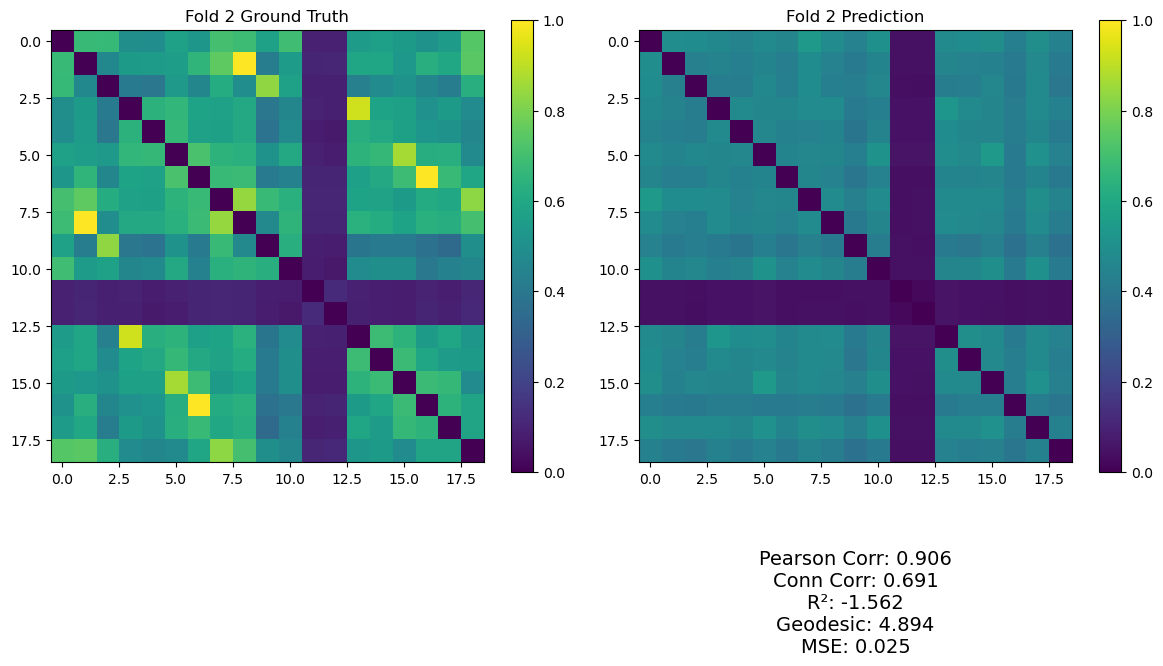

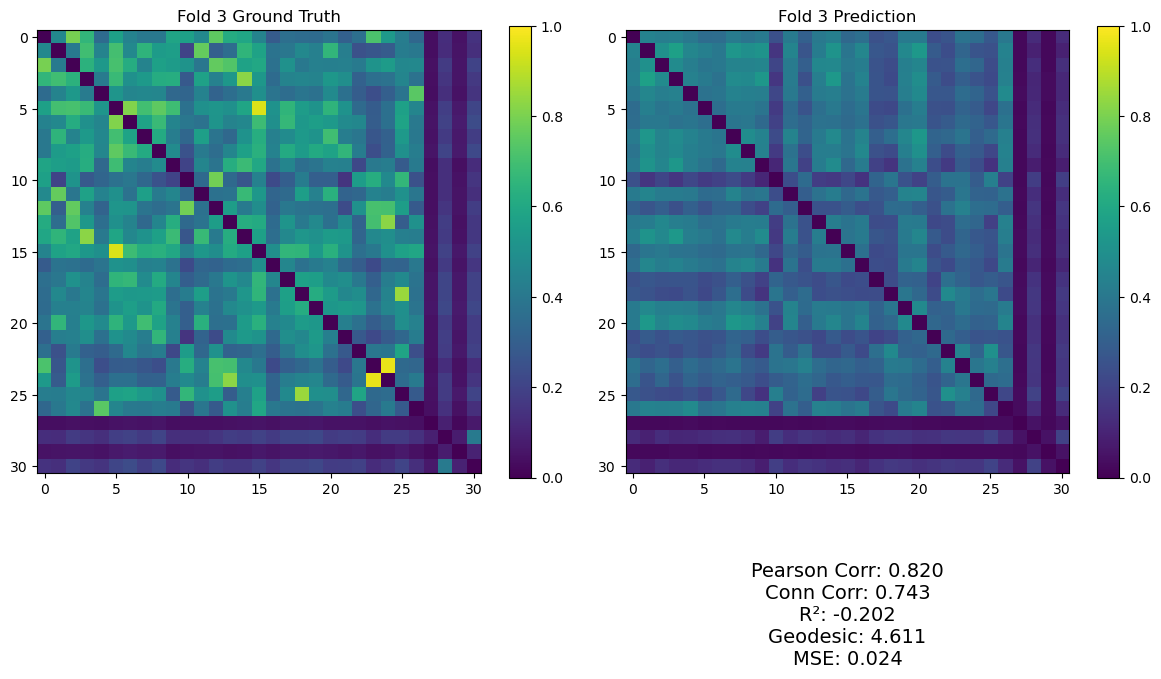

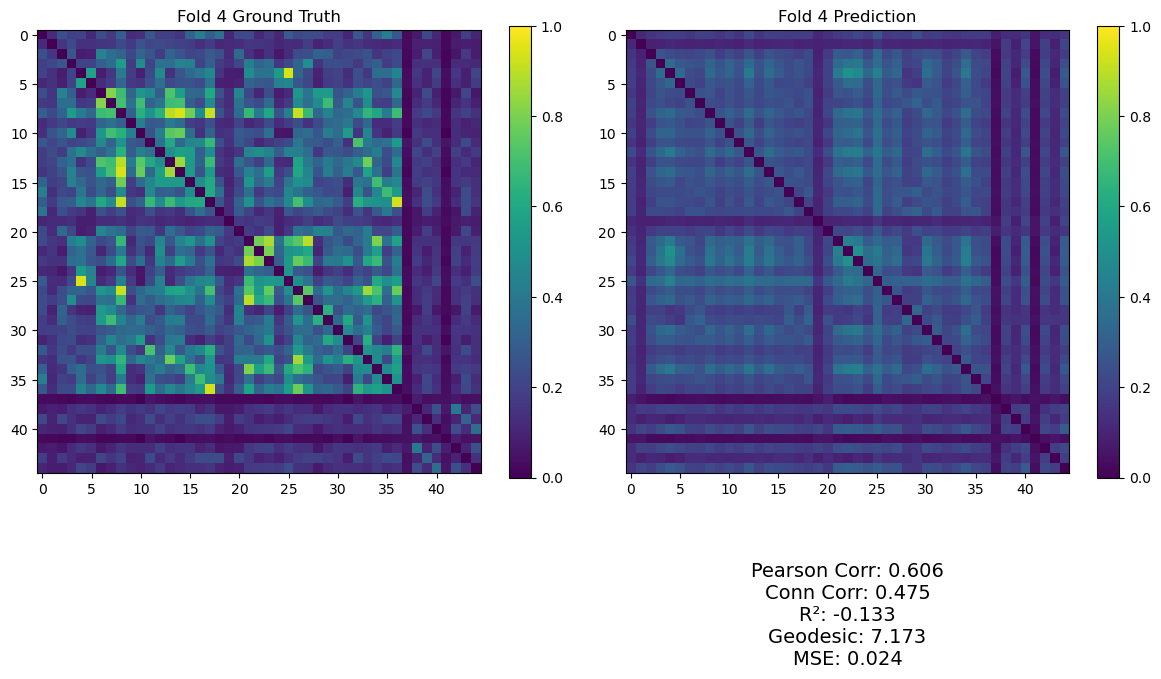

In [57]:
plot_single_model_predictions_with_metrics(conn_xgb_community_sim_results)

In [75]:
trans_xgb_community_sim_results = single_sim_run(
                                              'trans only',
                                              'community',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=False, 
                                              test_shared_regions=False, 
                                              resolution=1.02)
'''
best_params = {
            'n_estimators': [150],
            'max_depth': [5],           # Maximum depth of each tree - makes a big diff
            'learning_rate': [0.1],     # Learning rate (shrinkage)
            'subsample': [1],              # Subsample ratio of the training data
            'colsample_bytree': [0.5],  # Subsample ratio of columns when constructing each tree
            'gamma': [0],             # Minimum loss reduction required to make a split
            'reg_lambda': [1],              # L2 regularization term (Ridge penalty)
            'reg_alpha': [0.1],             # L1 regularization term (Lasso penalty)
            'random_state': [42],        # Seed for reproducibility
            'min_child_weight': [3], 
            'tree_method':['hist'],  # Use the GPU
            'device':['cuda'],  # Use GPU predictor
            'verbosity': [2]
        }
'''
# DONE 

Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(8930, 22106) (8930,) (342, 22106) (342,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.5, device=cuda, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=150, random_state=42, reg_alpha=0.1, reg_lambda=1, subsample=1, tree_method=hist, verbosity=2; total time=   1.6s
[CV] END colsample_bytree=0.5, device=cuda, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=150, random_state=42, reg_alpha=0.1, reg_lambda=1, subsample=1, tree_method=hist, verbosity=2; total time=   1.3s
[CV] END colsample_bytree=0.5, device=cuda, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=150, random_state=42, reg_alpha=0.1, reg_lambda=1, subsample=1, tree_method=hist, verbosity=2; total time=   1.0s

Grid Search CV Results:
Best P

"\nbest_params = {\n            'n_estimators': [150],\n            'max_depth': [5],           # Maximum depth of each tree - makes a big diff\n            'learning_rate': [0.1],     # Learning rate (shrinkage)\n            'subsample': [1],              # Subsample ratio of the training data\n            'colsample_bytree': [0.5],  # Subsample ratio of columns when constructing each tree\n            'gamma': [0],             # Minimum loss reduction required to make a split\n            'reg_lambda': [1],              # L2 regularization term (Ridge penalty)\n            'reg_alpha': [0.1],             # L1 regularization term (Lasso penalty)\n            'random_state': [42],        # Seed for reproducibility\n            'min_child_weight': [3], \n            'tree_method':['hist'],  # Use the GPU\n            'device':['cuda'],  # Use GPU predictor\n            'verbosity': [2]\n        }\n"

In [95]:
save_sims_finetune(trans_xgb_community_sim_results, 'trans only', 'community', 'xgboost', False, False, 1.02)

Multi simulation results have been saved.


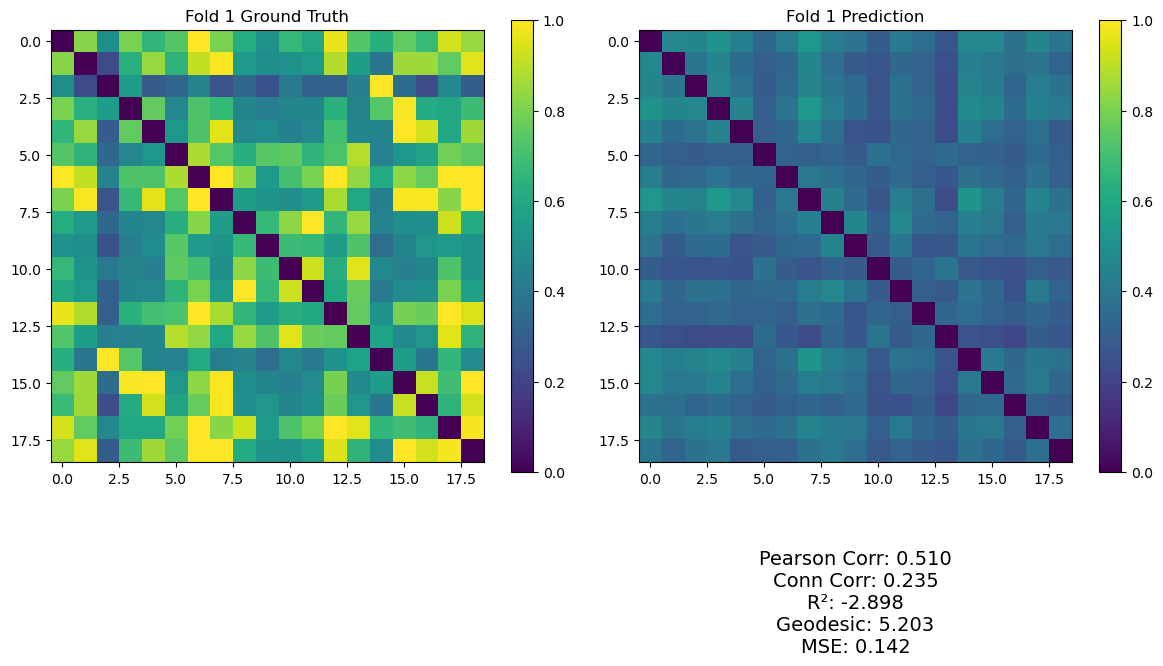

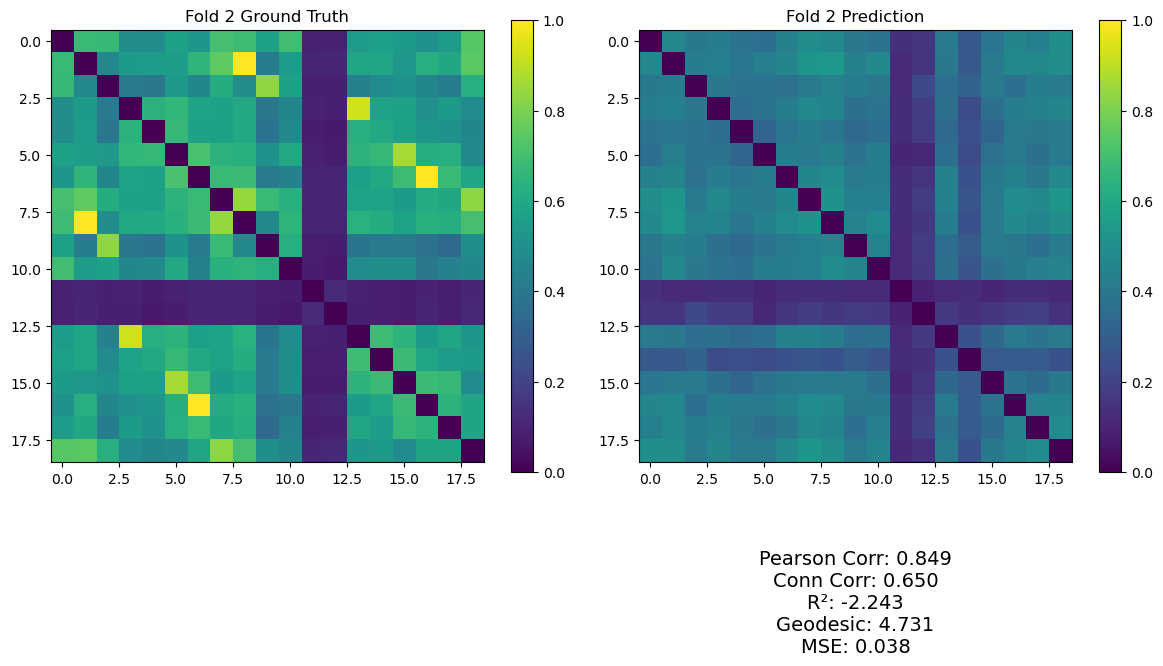

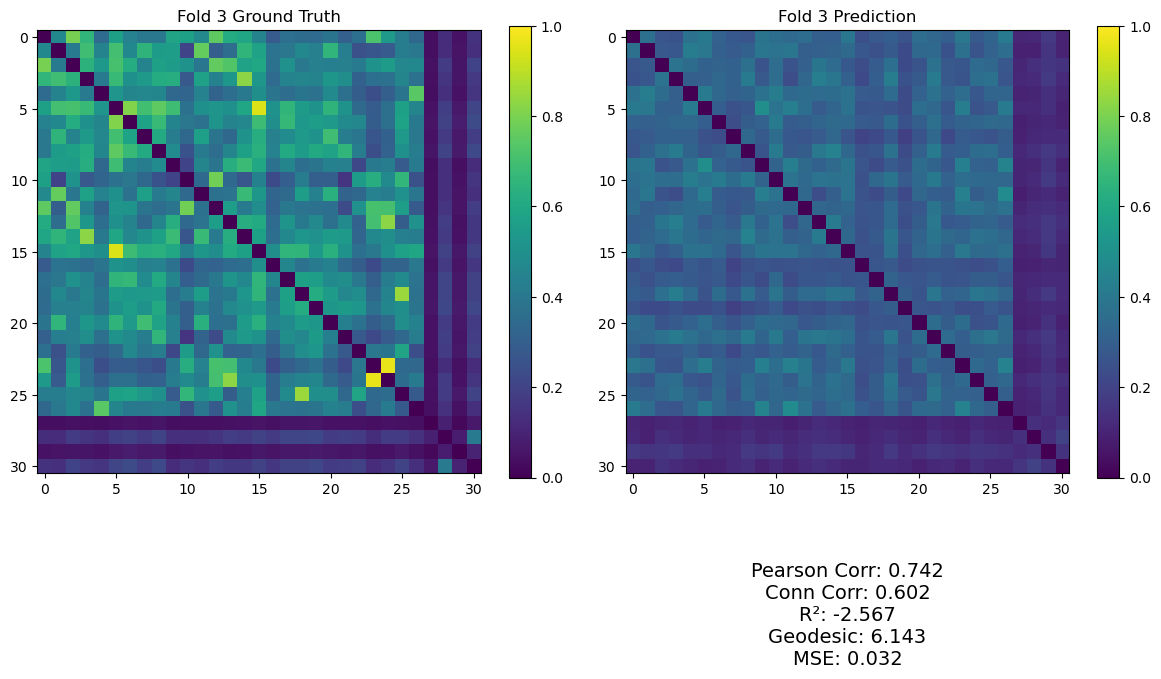

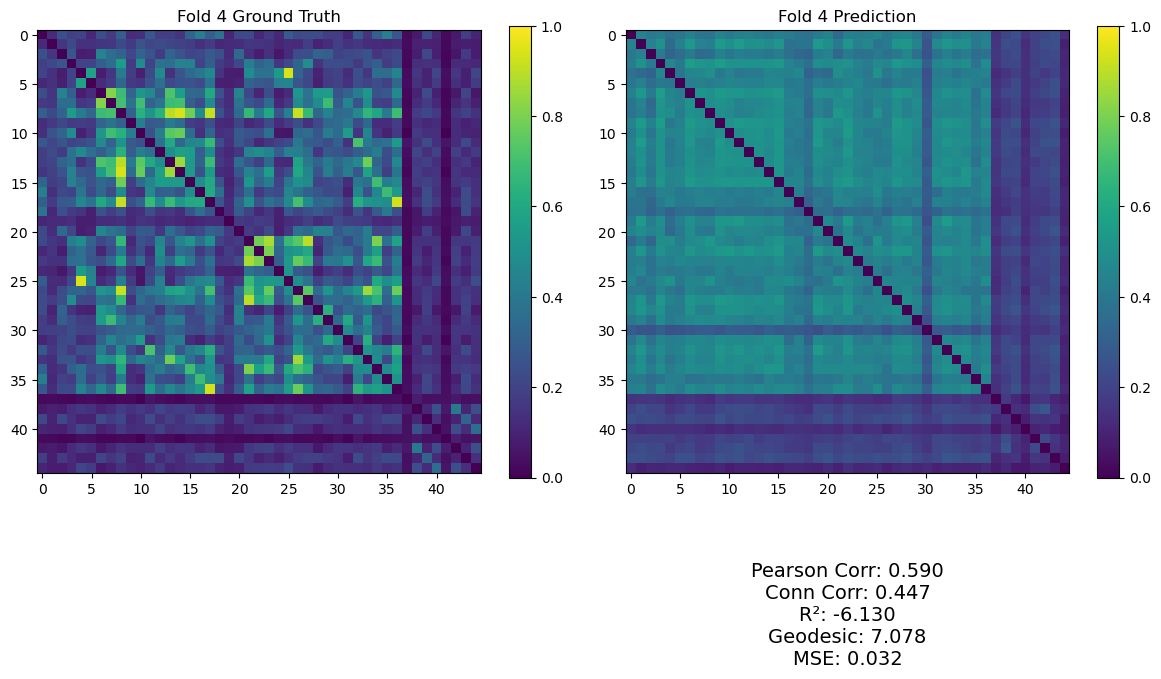

In [76]:
plot_single_model_predictions_with_metrics(trans_xgb_community_sim_results)

In [84]:
transconn_xgb_community_sim_results = single_sim_run(
                                              'trans plus conn',
                                              'community',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=False, 
                                              test_shared_regions=False,
                                              resolution=1.02)

'''
best_params = {
            'n_estimators': [250],
            'max_depth': [3],           # Maximum depth of each tree - makes a big diff
            'learning_rate': [0.01],     # Learning rate (shrinkage)
            'subsample': [0.6],              # Subsample ratio of the training data
            'colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree
            'gamma': [0],             # Minimum loss reduction required to make a split
            'reg_lambda': [.01],              # L2 regularization term (Ridge penalty)
            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)
            'random_state': [42],        # Seed for reproducibility
            'min_child_weight': [1], 
            'tree_method':['hist'],  # Use the GPU
            'device':['cuda'],  # Use GPU predictor
            'verbosity': [2]
        }
'''
# DONE

Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(8930, 22296) (8930,) (342, 22296) (342,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=0.8, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, tree_method=hist, verbosity=2; total time=   1.8s

Grid Search CV Results:
Best Cross-Validation Score:  0.8529335345283215
Best Parameters:  {'colsample_bytree': 0.8, 'device': 'cuda', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.6, 'tree_method': 'hist', 'verbosity': 2}
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END colsample_bytree=0.8, device=cuda, gamma=0, learning_rate=0.01, max_depth

"\nbest_params = {\n            'n_estimators': [250],\n            'max_depth': [3],           # Maximum depth of each tree - makes a big diff\n            'learning_rate': [0.01],     # Learning rate (shrinkage)\n            'subsample': [0.6],              # Subsample ratio of the training data\n            'colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree\n            'gamma': [0],             # Minimum loss reduction required to make a split\n            'reg_lambda': [.01],              # L2 regularization term (Ridge penalty)\n            'reg_alpha': [0.01],             # L1 regularization term (Lasso penalty)\n            'random_state': [42],        # Seed for reproducibility\n            'min_child_weight': [1], \n            'tree_method':['hist'],  # Use the GPU\n            'device':['cuda'],  # Use GPU predictor\n            'verbosity': [2]\n        }\n"

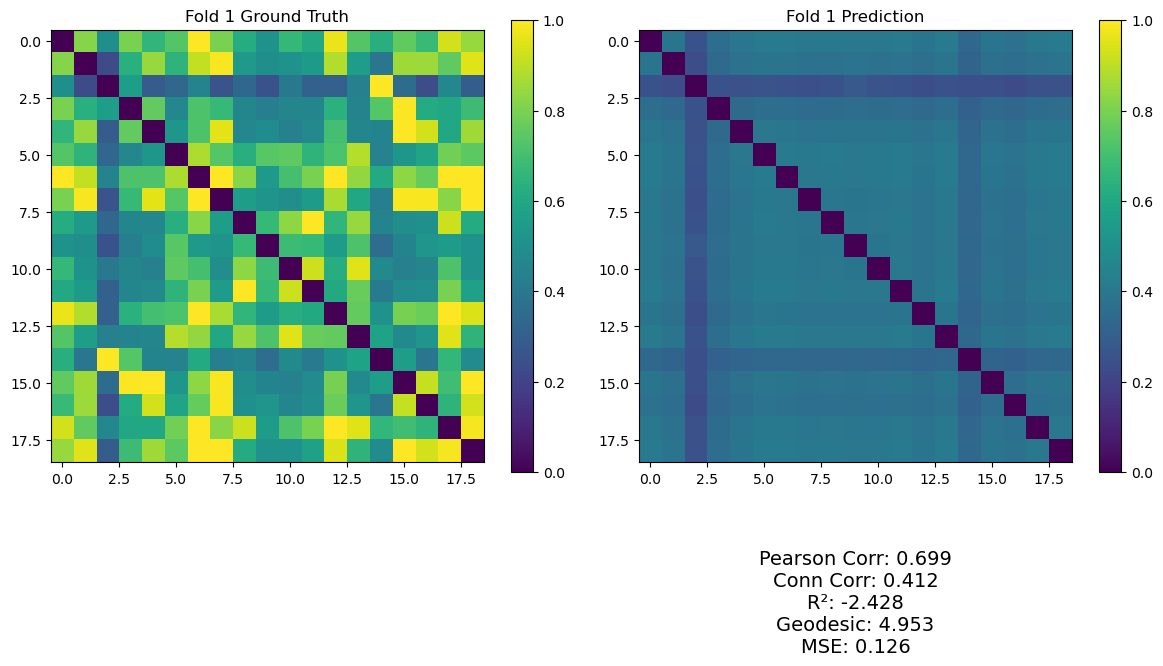

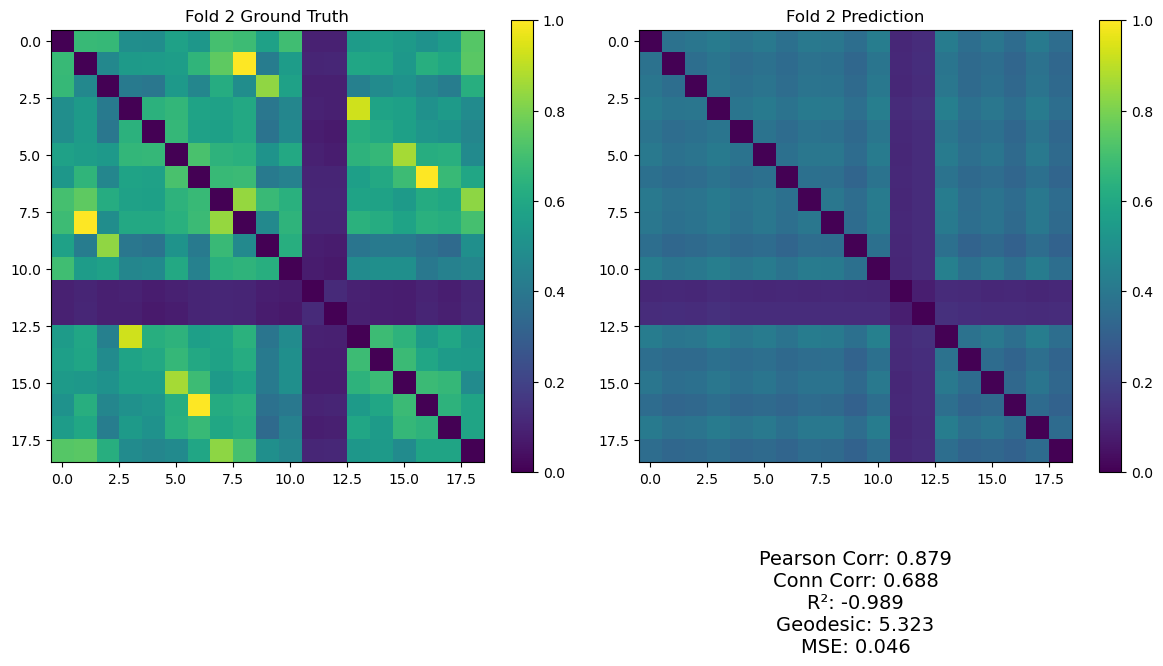

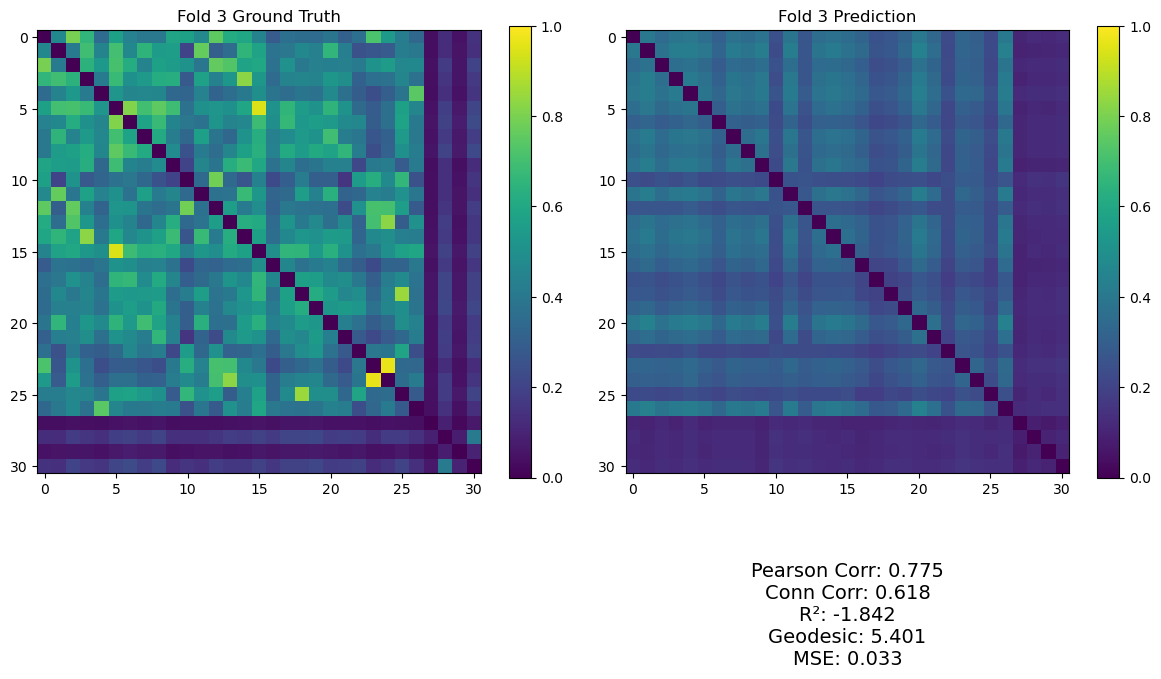

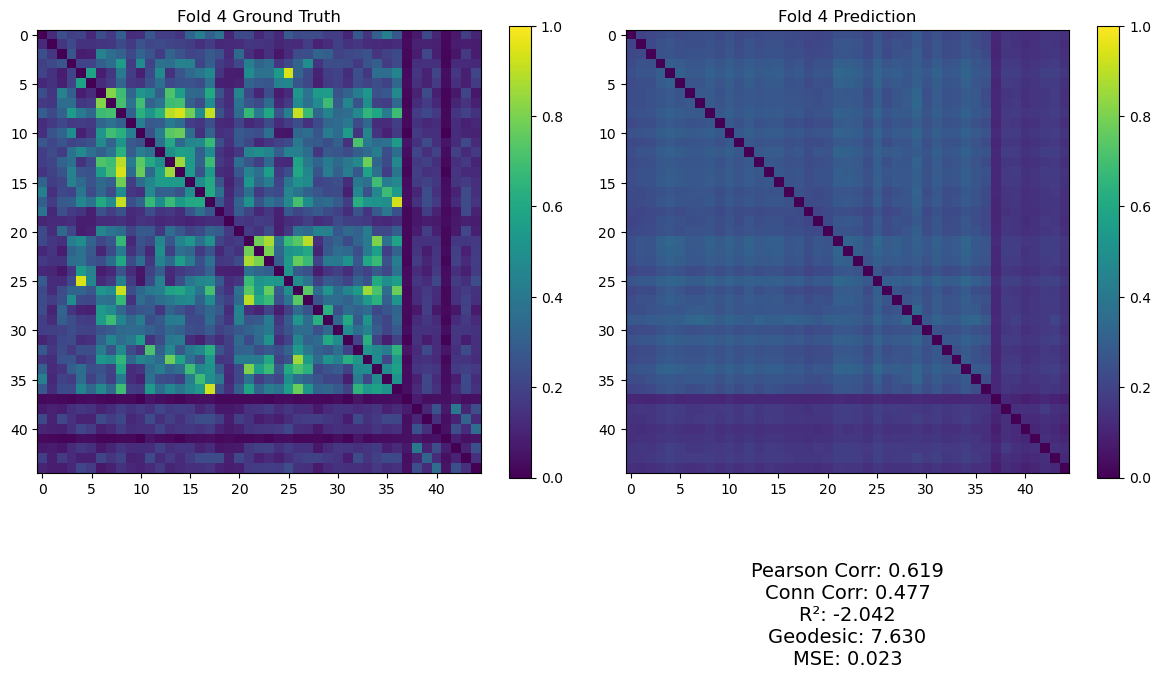

In [85]:
plot_single_model_predictions_with_metrics(transconn_xgb_community_sim_results)

### Feature importance analysis

In [18]:
def extract_feature_importances(results):
    """
    Extract feature importances from the simulation results.
    
    Parameters:
    results (list): List of simulation results for each fold.
    
    Returns:
    np.ndarray: Array of feature importances for each fold.
    """
    feature_importances = []
    
    for fold_results in results:
        importances = fold_results['feature_importances']
        feature_importances.append(importances)
    
    feature_importances = np.array(feature_importances)
    return feature_importances

import matplotlib.pyplot as plt


def plot_individual_feature_importances(feature_importances):
    """
    Plot the feature importances for each fold individually.
    
    Parameters:
    feature_importances (np.ndarray): Array of feature importances for each fold.
    """
    num_folds = feature_importances.shape[0]
    
    for fold_idx in range(num_folds):
        plt.figure(figsize=(12, 6))
        plt.plot(feature_importances[fold_idx])
        plt.xlabel('Features')
        plt.ylabel('Gain')
        plt.title(f'Feature Importances for Fold {fold_idx + 1}')
        plt.grid(True)
        plt.show()
        
def plot_feature_importances(feature_importances):
    """
    Plot the feature importances for each fold.
    
    Parameters:
    feature_importances (np.ndarray): Array of feature importances for each fold.
    """
    num_folds = feature_importances.shape[0]
    
    plt.figure(figsize=(12, 6))
    
    for fold_idx in range(num_folds):
        plt.plot(feature_importances[fold_idx], label=f'Fold {fold_idx + 1}')
    
    plt.xlabel('Features')
    plt.ylabel('Gain')
    plt.title('Feature Importances for Each Fold')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_feature_importances_as_mean(feature_importances):
    """
    Plot the feature importances for each fold individually and the mean feature importance across all folds.
    
    Parameters:
    feature_importances (np.ndarray): Array of feature importances for each fold.
    """
    num_folds = feature_importances.shape[0]
    
    # Plot mean feature importances
    mean_feature_importances = np.mean(feature_importances, axis=0)
    
    plt.figure(figsize=(12, 6))
    plt.plot(mean_feature_importances, color='red')
    plt.xlabel('Genes')
    plt.ylabel('Gain')
    plt.title('Mean Feature Importances Across All Folds')
    plt.grid(True)
    plt.show()

    return mean_feature_importances


def normalize_feature_importances(feature_importances):
    """
    Normalize feature importances to be between 0 and 1.
    
    Parameters:
    feature_importances (np.ndarray): Array of feature importances.
    
    Returns:
    np.ndarray: Normalized feature importances.
    """
    # Handle NoneType and NaN values
    feature_importances = np.array(feature_importances)
    feature_importances = np.nan_to_num(feature_importances, nan=0.0)

    min_val = np.min(feature_importances)
    max_val = np.max(feature_importances)
    
    # Prevent division by zero
    if max_val == min_val:
        return feature_importances
    
    normalized = (feature_importances - min_val) / (max_val - min_val)
    return normalized






In [19]:
trans_xgb_community_shared_sim_results = open_pickled_results('finetune_single_sim_trans_community_xgboost1.02_useshared_trainshared.pickle')
trans_xgb_community_shared_sim_results = trans_xgb_community_shared_sim_results[0]

In [20]:
trans_xgb_community_shared_sim_results

[{'model_parameters': {'objective': 'reg:squarederror',
   'base_score': None,
   'booster': None,
   'callbacks': None,
   'colsample_bylevel': None,
   'colsample_bynode': None,
   'colsample_bytree': 1,
   'device': 'cuda',
   'early_stopping_rounds': None,
   'enable_categorical': False,
   'eval_metric': None,
   'feature_types': None,
   'gamma': 0,
   'grow_policy': None,
   'importance_type': None,
   'interaction_constraints': None,
   'learning_rate': 0.1,
   'max_bin': None,
   'max_cat_threshold': None,
   'max_cat_to_onehot': None,
   'max_delta_step': None,
   'max_depth': 7,
   'max_leaves': None,
   'min_child_weight': 3,
   'missing': nan,
   'monotone_constraints': None,
   'multi_strategy': None,
   'n_estimators': 200,
   'n_jobs': None,
   'num_parallel_tree': None,
   'random_state': 42,
   'reg_alpha': 0.1,
   'reg_lambda': 1,
   'sampling_method': None,
   'scale_pos_weight': None,
   'subsample': 1,
   'tree_method': 'hist',
   'validate_parameters': None,
   '

In [21]:
trans_xgb_community_shared_sim_feature_importances = extract_feature_importances(trans_xgb_community_shared_sim_results)


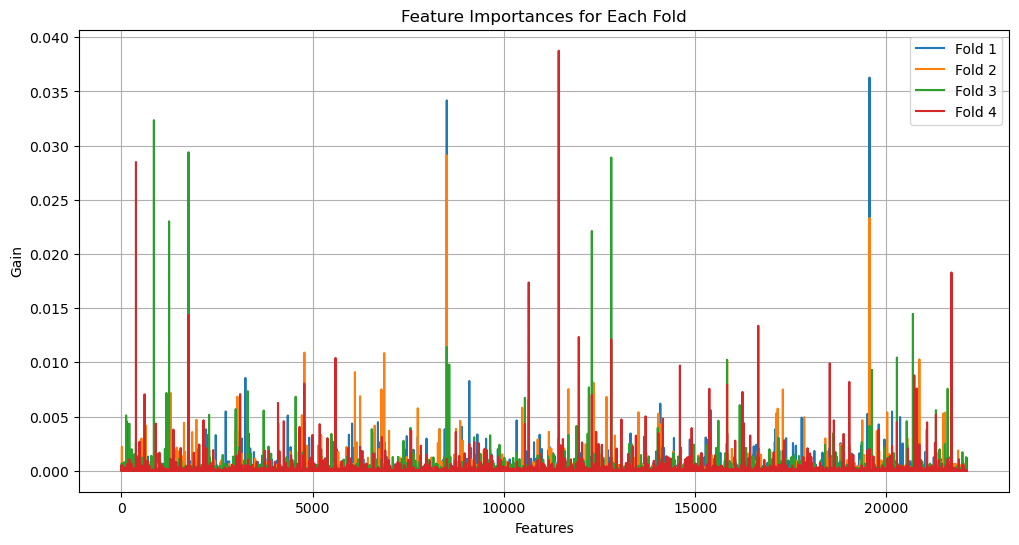

In [22]:
plot_feature_importances(trans_xgb_community_shared_sim_feature_importances)

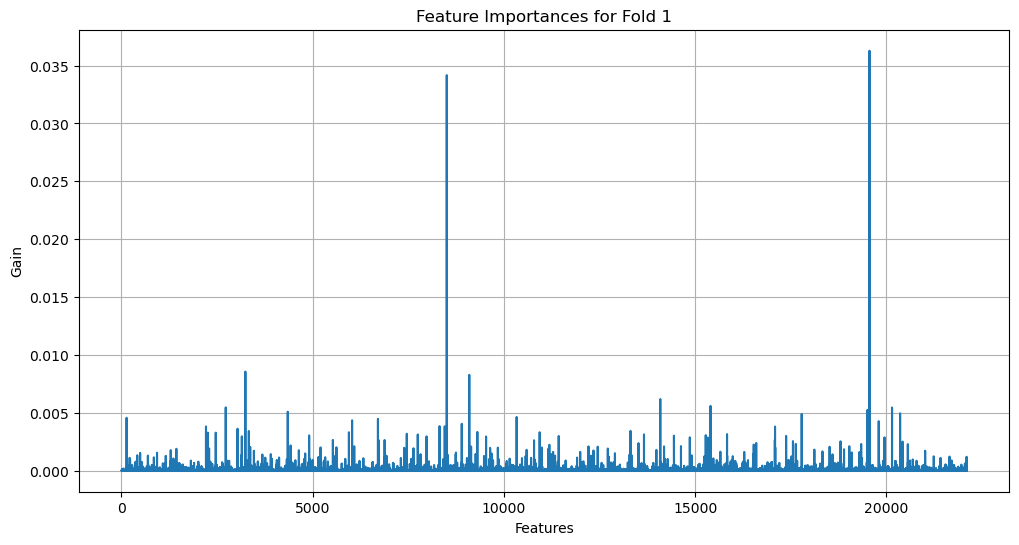

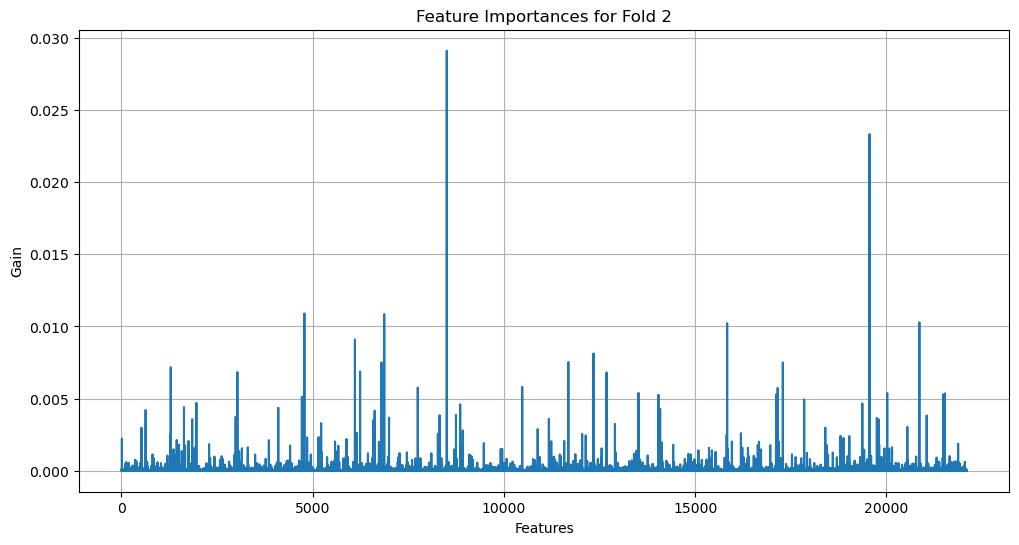

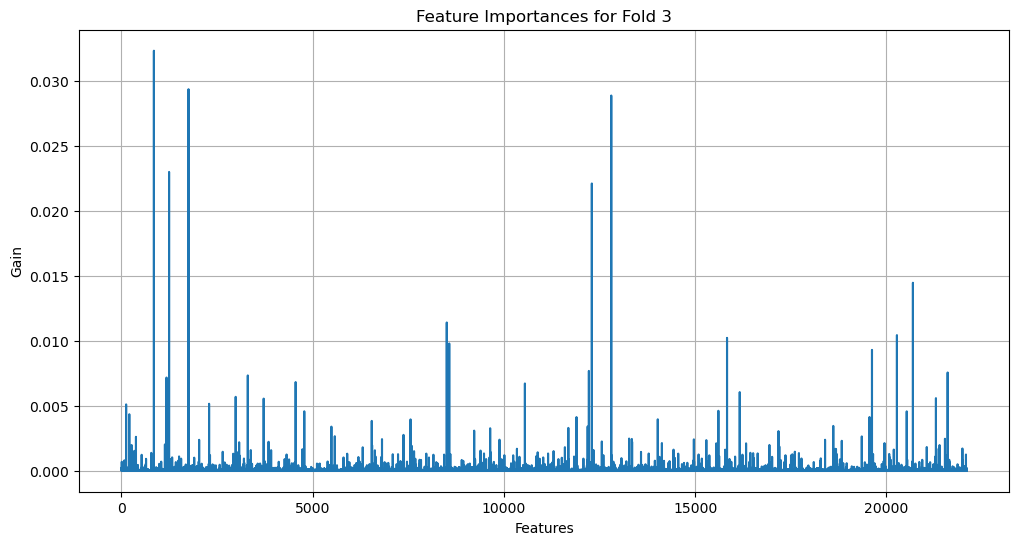

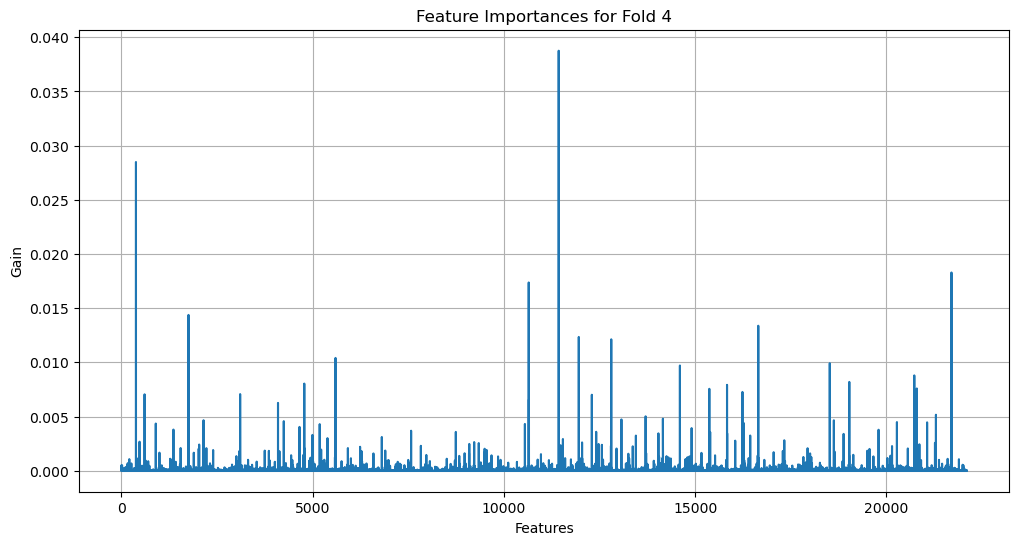

In [23]:
plot_individual_feature_importances(trans_xgb_community_shared_sim_feature_importances)

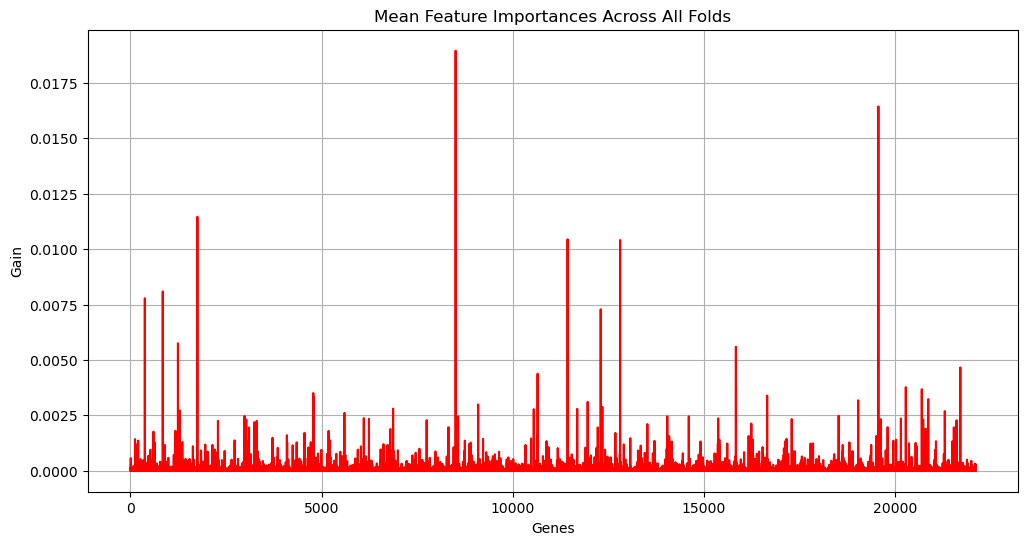

In [24]:
trans_xgb_community_shared_sim_feature_importances_mean = plot_feature_importances_as_mean(trans_xgb_community_shared_sim_feature_importances)
trans_xgb_community_shared_sim_feature_importances_mean_norm = normalize_feature_importances(trans_xgb_community_shared_sim_feature_importances_mean)


In [25]:
trans_xgb_community_testshared_sim_results = open_pickled_results('finetune_single_sim_trans_community_xgboost1.02_useshared_testshared.pickle')
trans_xgb_community_testshared_sim_results = trans_xgb_community_testshared_sim_results[0]
trans_xgb_community_testshared_sim_feature_importances = extract_feature_importances(trans_xgb_community_testshared_sim_results)


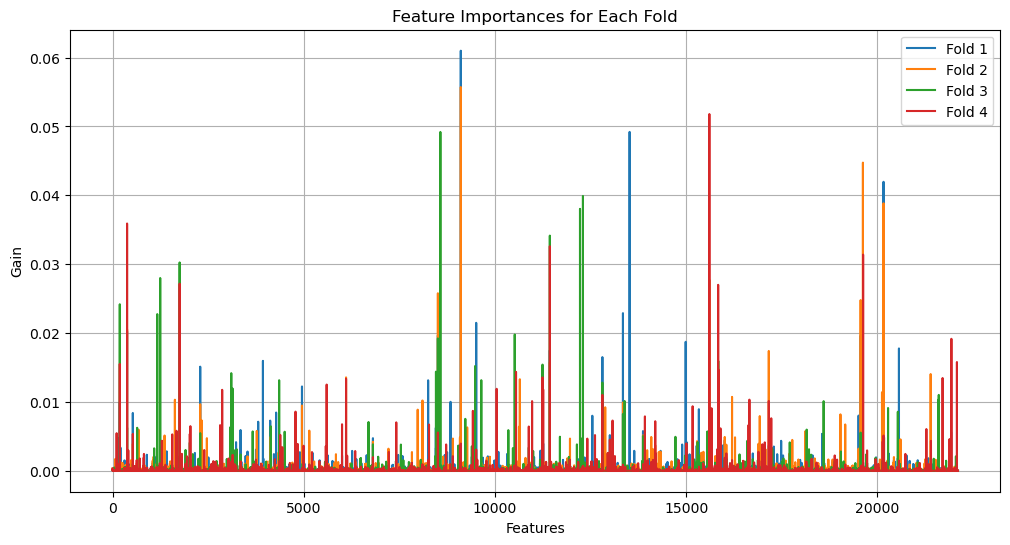

In [26]:
plot_feature_importances(trans_xgb_community_testshared_sim_feature_importances)

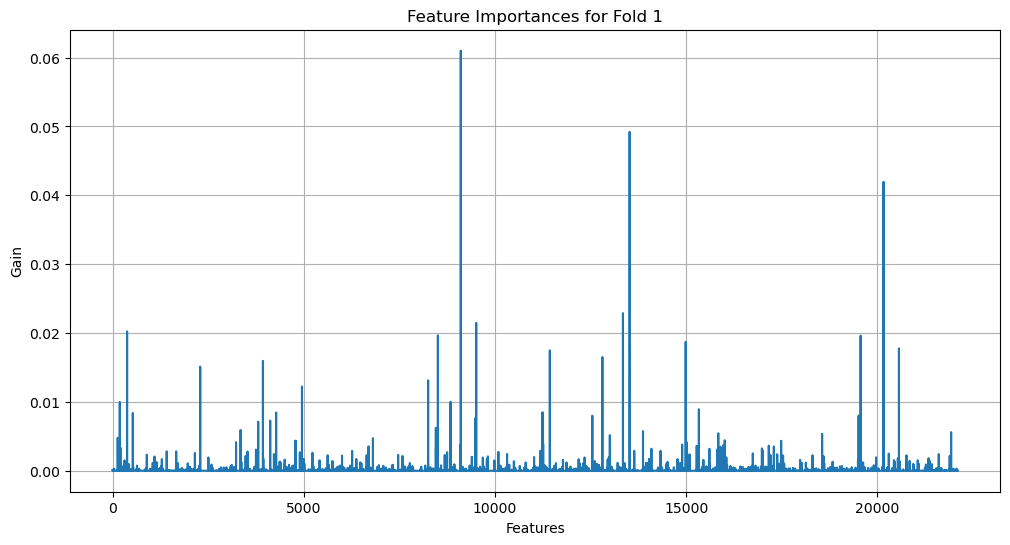

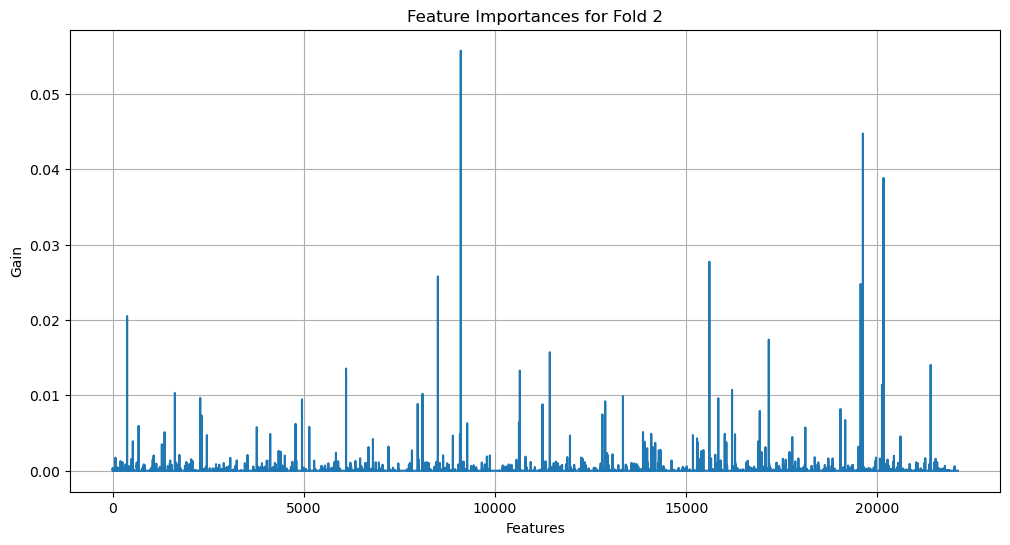

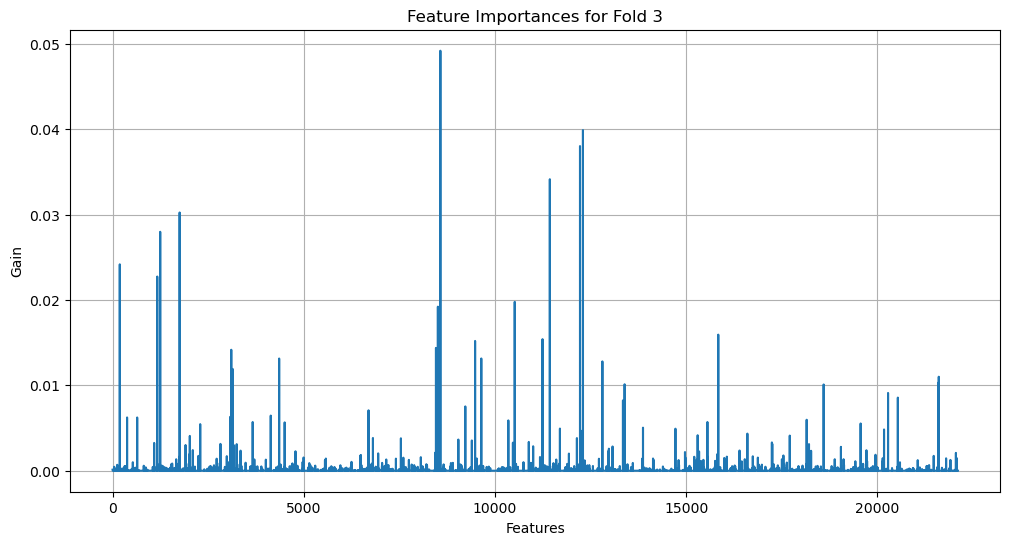

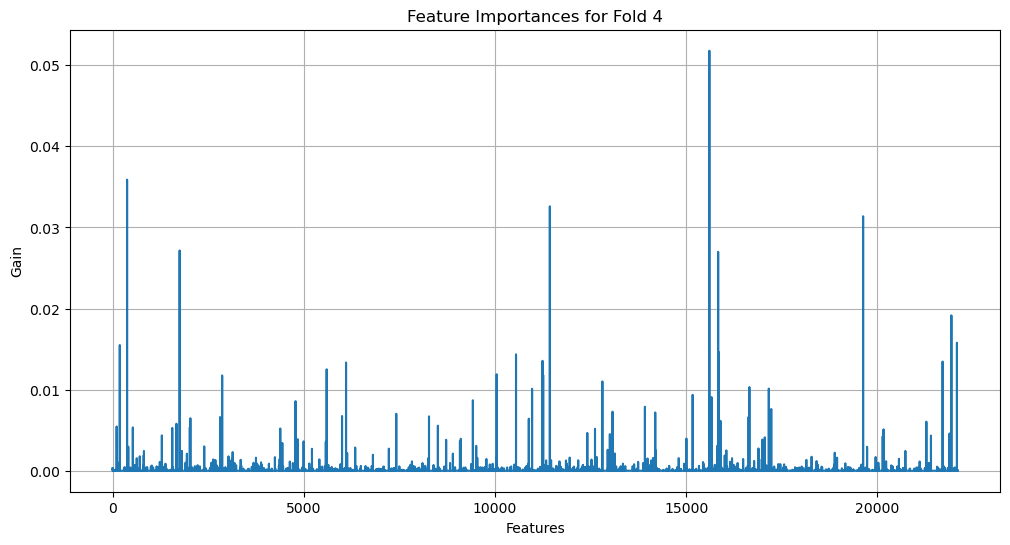

In [27]:
plot_individual_feature_importances(trans_xgb_community_testshared_sim_feature_importances)

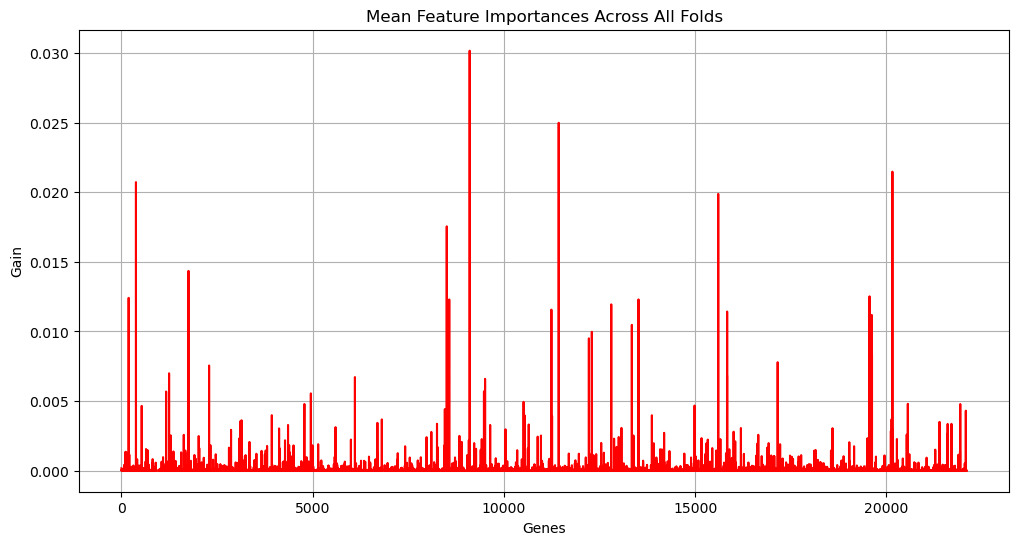

In [28]:
trans_xgb_community_testshared_sim_feature_importances_mean = plot_feature_importances_as_mean(trans_xgb_community_testshared_sim_feature_importances)
trans_xgb_community_testshared_sim_feature_importances_mean_norm = normalize_feature_importances(trans_xgb_community_testshared_sim_feature_importances_mean)


In [29]:
trans_xgb_community_sim_results = open_pickled_results('finetune_single_sim_trans_community_xgboost1.02.pickle')
trans_xgb_community_sim_results = trans_xgb_community_sim_results[0]
trans_xgb_community_sim_feature_importances = extract_feature_importances(trans_xgb_community_sim_results)


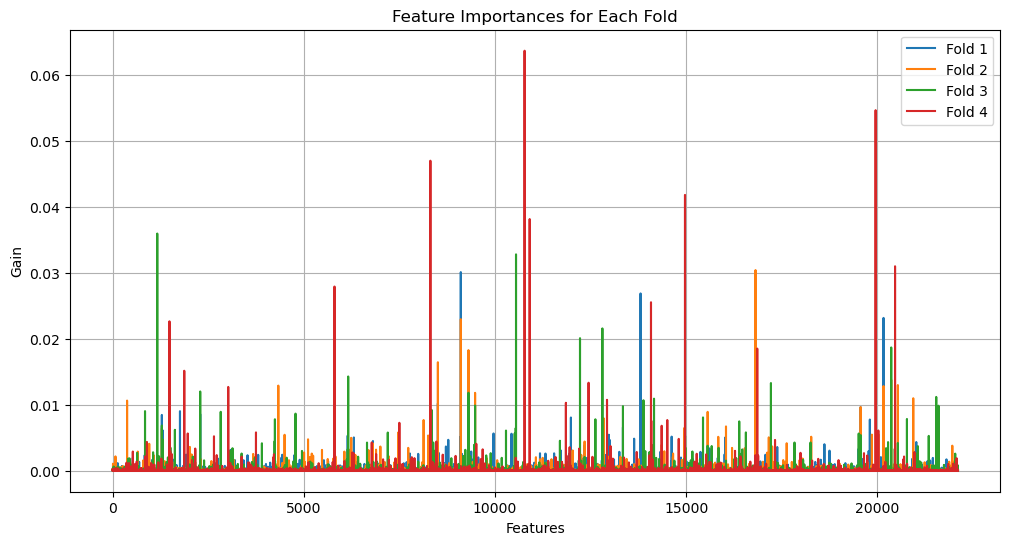

In [30]:
plot_feature_importances(trans_xgb_community_sim_feature_importances)

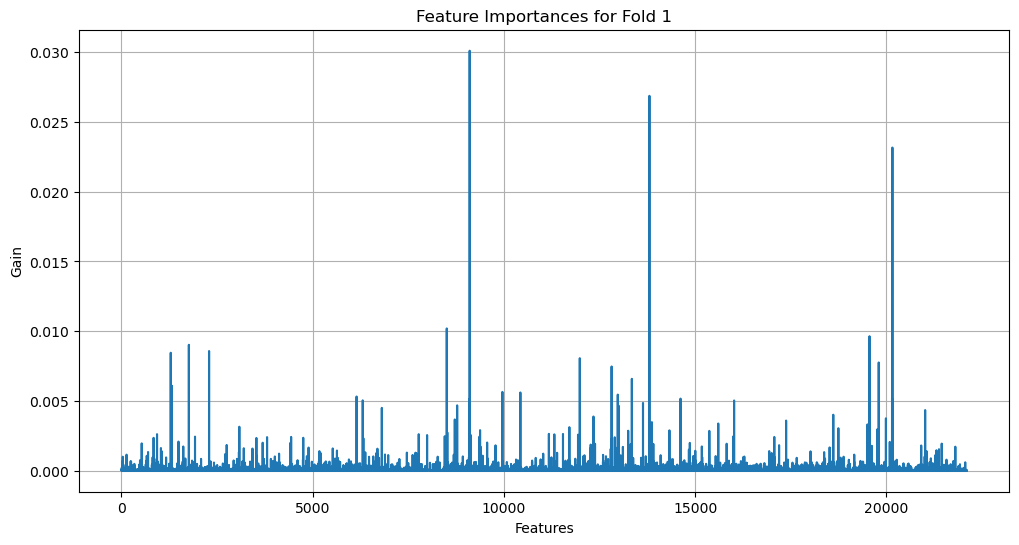

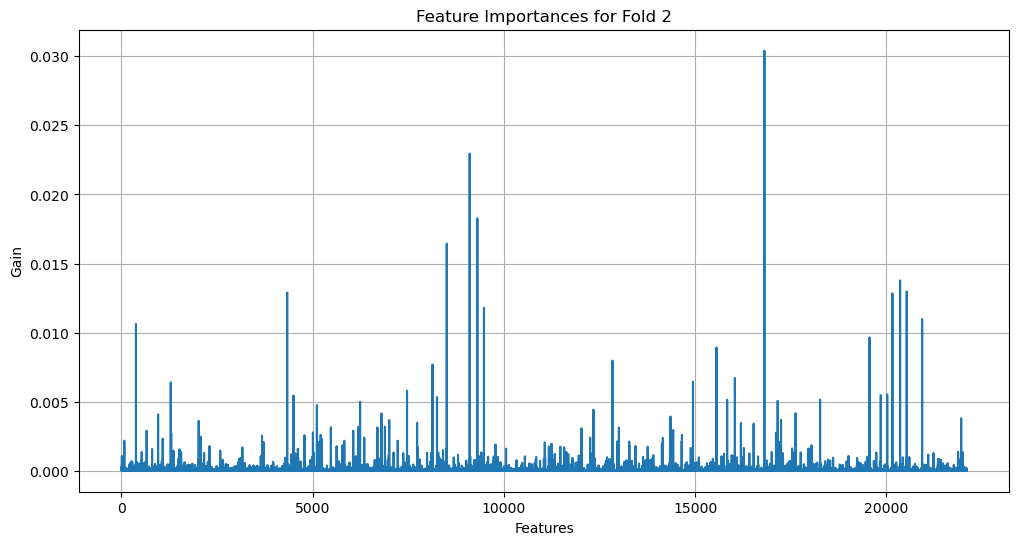

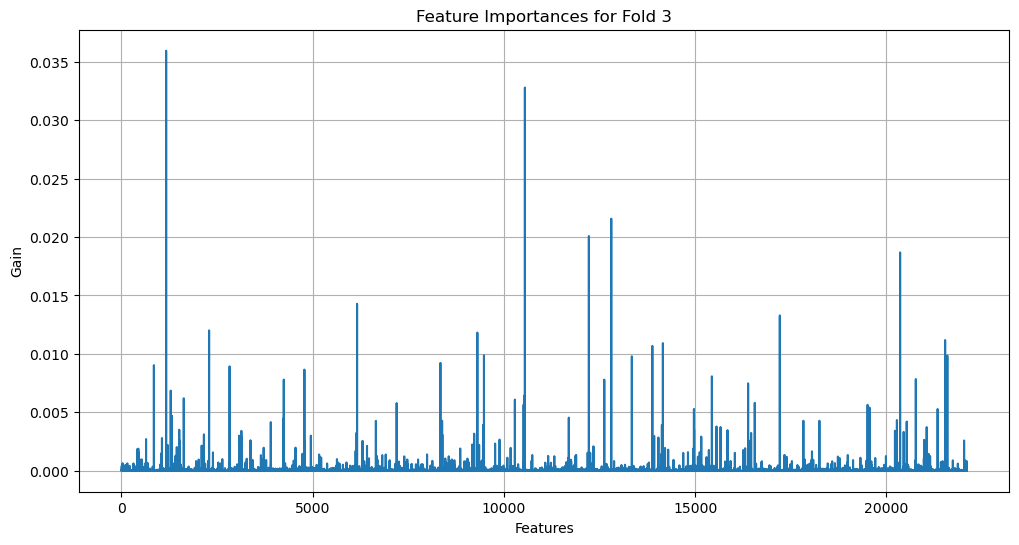

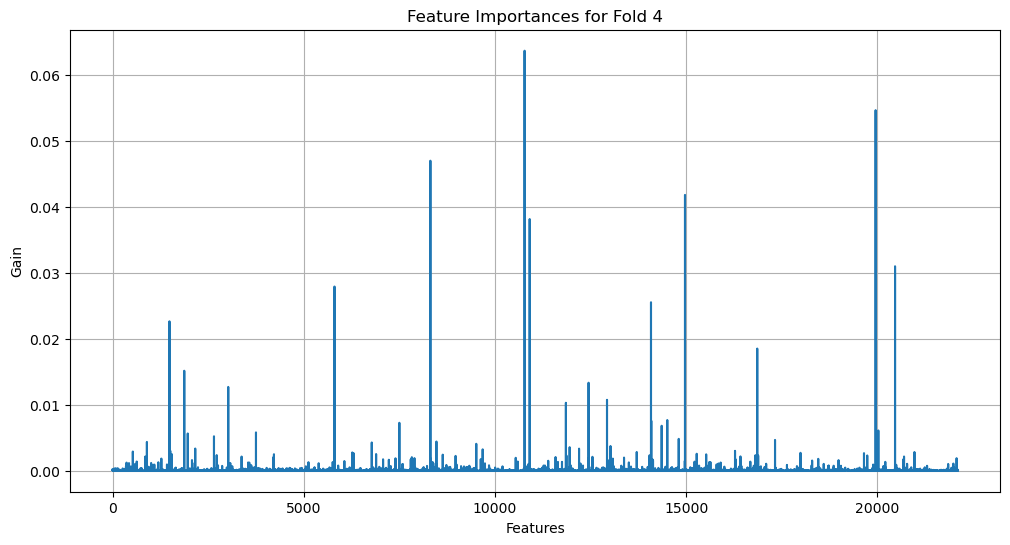

In [31]:
plot_individual_feature_importances(trans_xgb_community_sim_feature_importances)

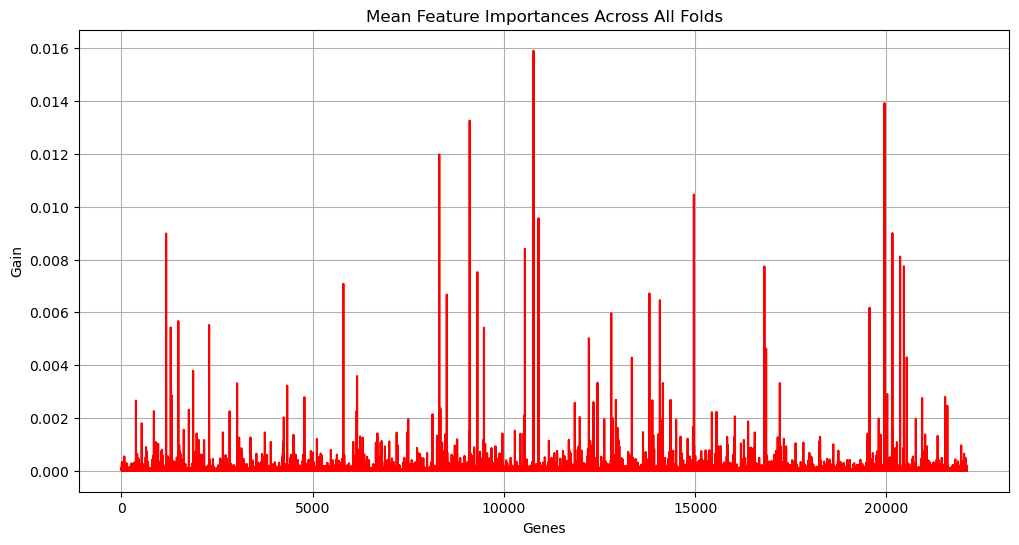

In [32]:
trans_xgb_community_sim_feature_importances_mean = plot_feature_importances_as_mean(trans_xgb_community_sim_feature_importances)
trans_xgb_community_sim_feature_importances_mean_norm = normalize_feature_importances(trans_xgb_community_sim_feature_importances_mean)


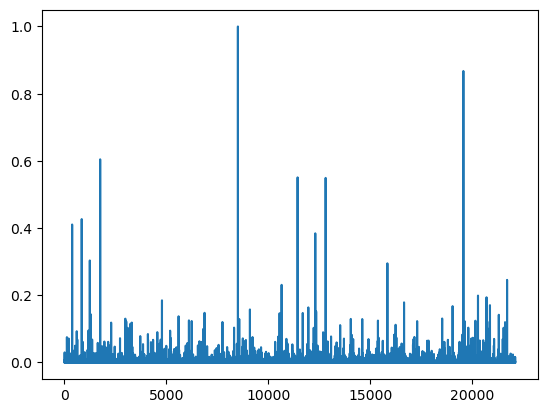

In [33]:
plt.plot(trans_xgb_community_shared_sim_feature_importances_mean_norm)

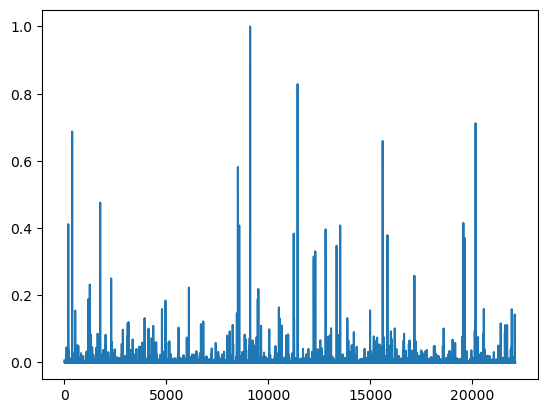

In [34]:
plt.plot(trans_xgb_community_testshared_sim_feature_importances_mean_norm)

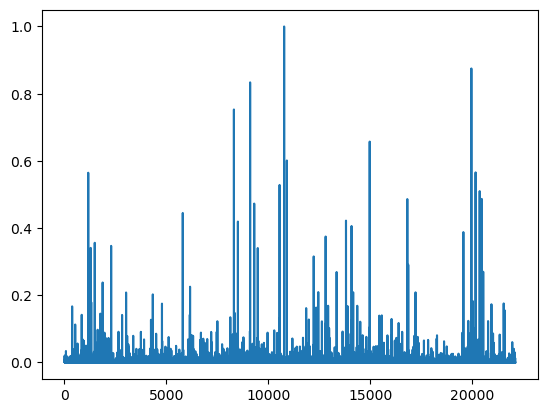

In [35]:
plt.plot(trans_xgb_community_sim_feature_importances_mean_norm)

Mean these 3 together and plot 

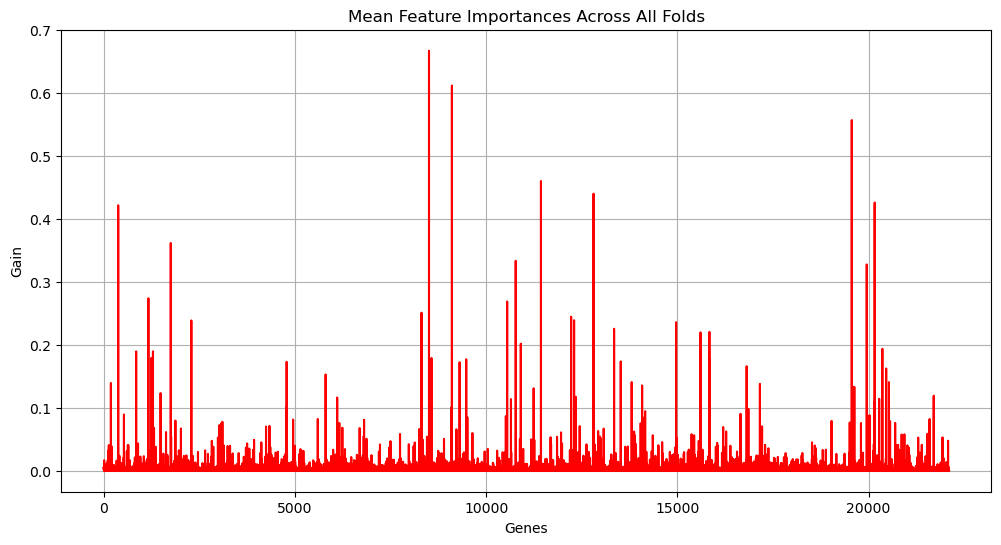

In [36]:
feature_importance_arr = np.array([trans_xgb_community_shared_sim_feature_importances_mean_norm, trans_xgb_community_testshared_sim_feature_importances_mean_norm, trans_xgb_community_sim_feature_importances_mean_norm])
all_model_feature_importance_mean = plot_feature_importances_as_mean(feature_importance_arr)

### Analyze canonical gene feature importance

In [37]:
# Grab gene names for downstream analysis

# Gene expression data in schaefer version with similarity threshold >0.2
schaefer114_genes = pd.read_csv('./data/enigma/allgenes_stable_r0.2_schaefer_100.csv')
schaefer114_genes.set_index('label', inplace=True)
gene_names = np.array(schaefer114_genes.columns.tolist())
print(len(gene_names))

11053


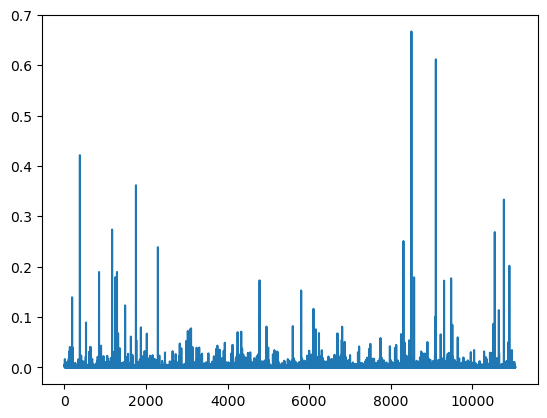

In [38]:
plt.plot(all_model_feature_importance_mean[:11053])

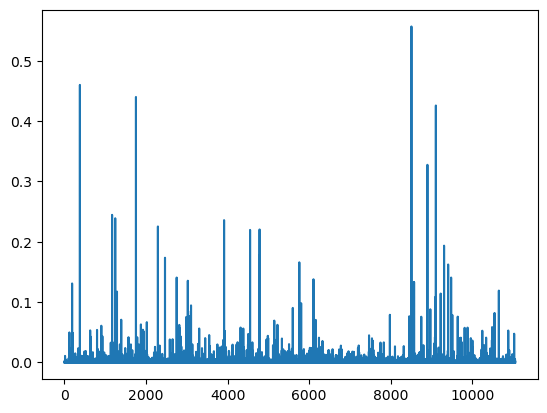

In [39]:
plt.plot(all_model_feature_importance_mean[11053:])

In [40]:
# again compute the average to get a mean list of feature importance for each gene of the 11,000 and normalize between 0 and 1
gene_mean_feature_importances = normalize_feature_importances((all_model_feature_importance_mean[11053:] + all_model_feature_importance_mean[:11053]) / 2)

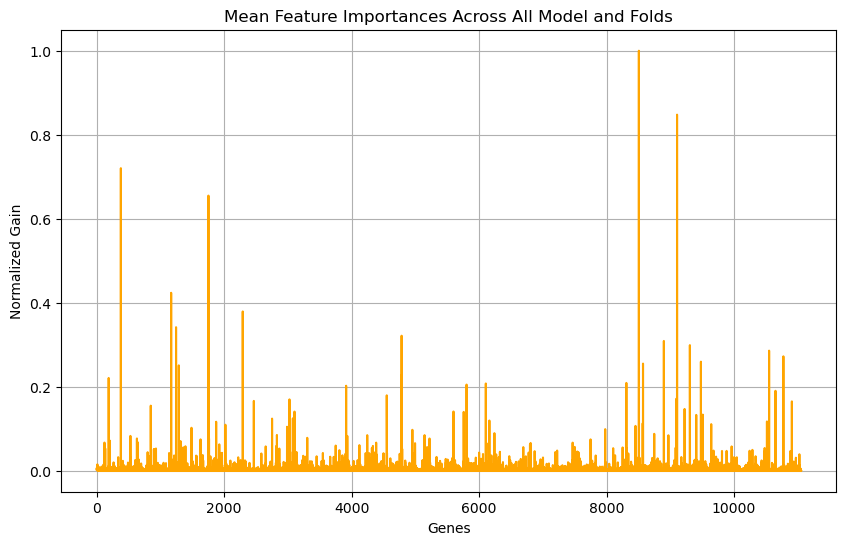

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(gene_mean_feature_importances, color='orange')
plt.xlabel('Genes')
plt.ylabel('Normalized Gain')
plt.title('Mean Feature Importances Across All Model and Folds')
plt.grid(True)
plt.show()

In [42]:
# Create importance DF
feature_importances_df = pd.DataFrame(gene_mean_feature_importances, index=gene_names, columns=['Feature Importance'])
feature_importances_df.head()

,Feature Importance
A1BG,0.003126
A1BG-AS1,0.006342
AAAS,0.002396
AACS,0.002009
AADAT,0.001807


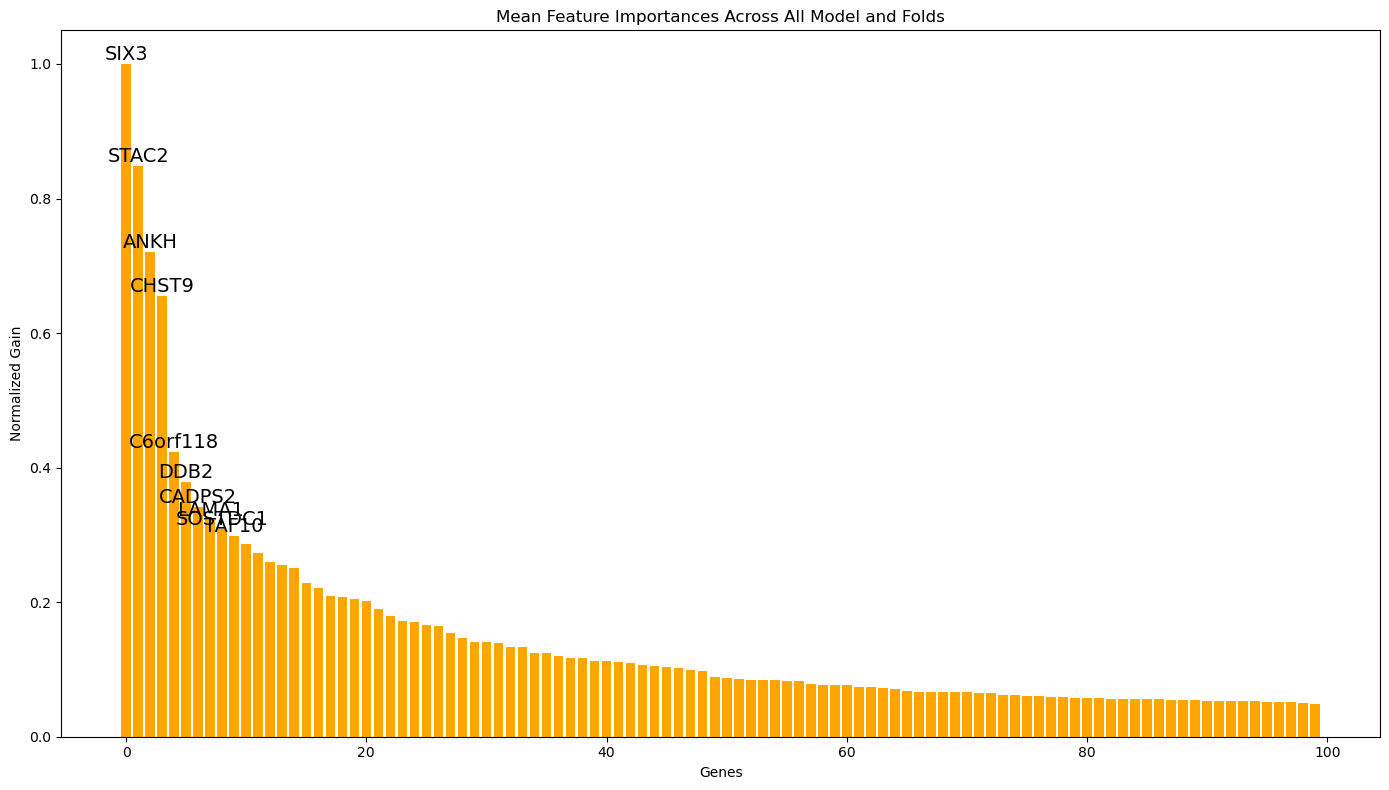

In [43]:
# Sort the DataFrame by the importance values
df_sorted = feature_importances_df.sort_values(by='Feature Importance', ascending=False)

# Select the first 500 genes
df_sorted_500 = df_sorted.head(100)

# Create a bar plot
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(df_sorted_500)), df_sorted_500['Feature Importance'], color='orange')

# Add labels and title
plt.xlabel('Genes')
plt.ylabel('Normalized Gain')
plt.title('Mean Feature Importances Across All Model and Folds')

# Label the top 10 genes
for i in range(10):
    plt.text(i, df_sorted['Feature Importance'].iloc[i], df_sorted.index[i], ha='center', va='bottom', fontsize=14, rotation=0)

plt.tight_layout()
plt.show()

In [50]:
# Define the top 10% genes
top_10_percent_genes = df_sorted.head(int(len(df_sorted) * 0.01))
print(len(top_10_percent_genes))

# Extract the gene names from the top 10% genes
top_gene_names_xgb = top_10_percent_genes.index.tolist()

# Define the gene set database for GO Biological Process
gene_set_db = 'GO_Biological_Process_2023' # GO_Molecular_Function_2023, GO_Cellular_Component_2023

# Perform pathway enrichment analysis using gseapy
enrichment_results = gp.enrichr(
    gene_list=top_gene_names_xgb,  # List of gene names
    gene_sets=gene_set_db,  # Gene set database
    organism='Human',  # Specify the organism (human in this case)
    outdir=None,  # Optional output directory for results
)

# Convert results to a pandas DataFrame for easier interpretation
enrichment_df = enrichment_results.results

# Display the top 20 most significant pathways
print("Top 10 significant pathways:")
print(enrichment_df.head(10))


110
Top 10 significant pathways:
                     Gene_set  \
0  GO_Biological_Process_2023   
1  GO_Biological_Process_2023   
2  GO_Biological_Process_2023   
3  GO_Biological_Process_2023   
4  GO_Biological_Process_2023   
5  GO_Biological_Process_2023   
6  GO_Biological_Process_2023   
7  GO_Biological_Process_2023   
8  GO_Biological_Process_2023   
9  GO_Biological_Process_2023   

                                                Term Overlap   P-value  \
0         Aminoglycan Metabolic Process (GO:0006022)     2/9  0.001052   
1            Melanocyte Differentiation (GO:0030318)    2/11  0.001596   
2                              Learning (GO:0007612)    3/43  0.001702   
3  Negative Regulation Of Hippo Signaling (GO:003...    2/12  0.001908   
4            Synaptic Membrane Adhesion (GO:0099560)    2/12  0.001908   
5  Resolution Of Meiotic Recombination Intermedia...    2/14  0.002613   
6           Cellular Response To Sterol (GO:0036315)    2/15  0.003004   
7      Gang

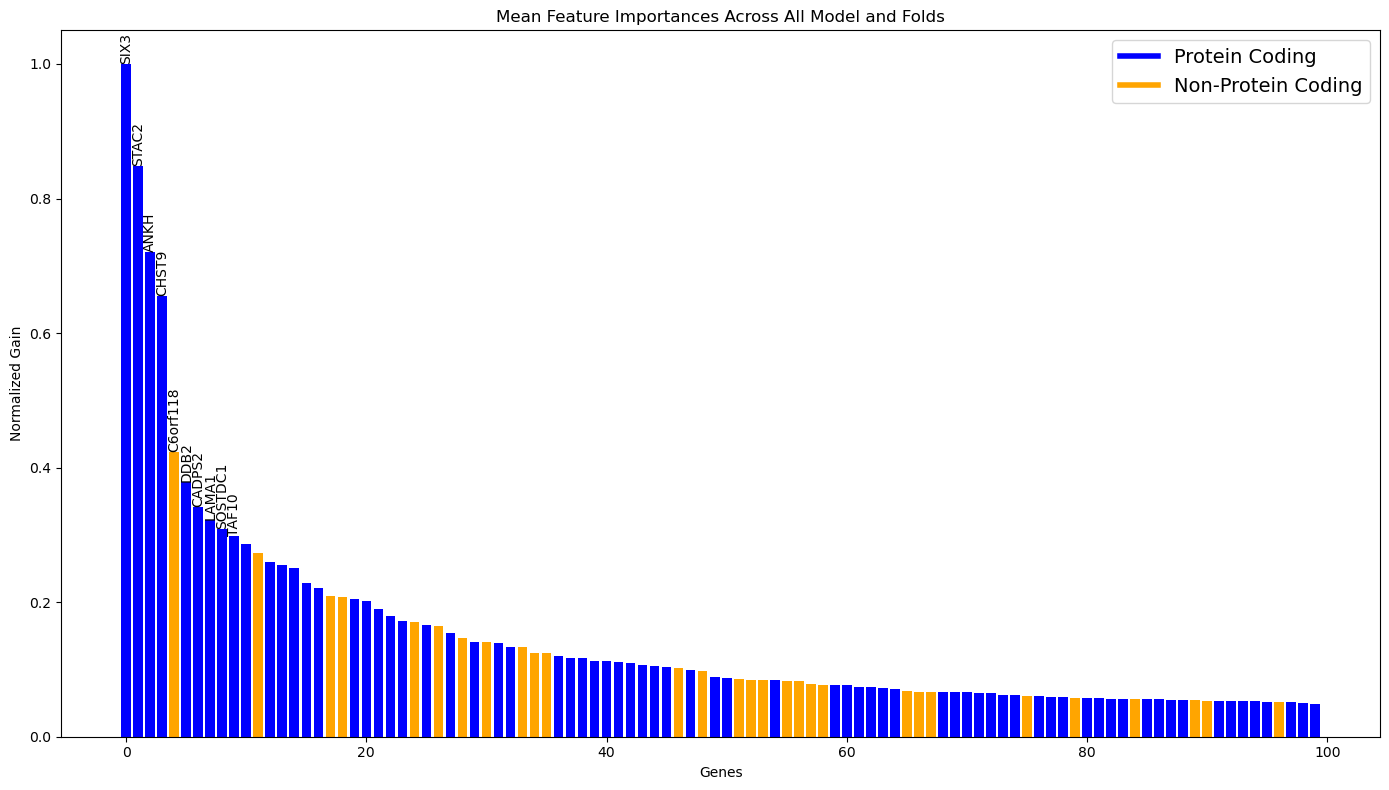

In [45]:

# Assume df_sorted_500 is the DataFrame with the top 500 genes
gene_list = df_sorted_500.index.tolist()

# Perform enrichment analysis using gseapy (Enrichr API)
enrichment_results = gp.enrichr(
    gene_list=gene_list,  # List of gene names
    gene_sets='GO_Biological_Process_2023',  # Gene set database
    organism='Human',  # Specify the organism (human in this case)
    outdir=None,  # Optional output directory for results
)

# Extract the enrichment results
enrichment_df = enrichment_results.results

# Filter for protein-coding genes (assuming protein-coding genes are enriched in specific terms)
# This is an indirect way and may not be perfect
protein_coding_genes = set()
for term_genes in enrichment_df['Genes']:
    for gene in term_genes.split(';'):
        protein_coding_genes.add(gene)

# Create a dictionary mapping gene names to their types
gene_type_dict = {gene: 'protein_coding' if gene in protein_coding_genes else 'non_protein_coding' for gene in gene_list}

# Create a color map based on gene type
colors = ['blue' if gene_type_dict.get(gene, 'non_protein_coding') == 'protein_coding' else 'orange' for gene in df_sorted_500.index]

# Create a bar plot
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(df_sorted_500)), df_sorted_500['Feature Importance'], color=colors)

# Add labels and title
plt.xlabel('Genes')
plt.ylabel('Normalized Gain')
plt.title('Mean Feature Importances Across All Model and Folds')

# Label the top 10 genes
for i in range(10):
    plt.text(i, df_sorted_500['Feature Importance'].iloc[i], df_sorted_500.index[i], ha='center', va='bottom', fontsize=10, rotation=90)

# Create a legend
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Protein Coding'),
                    plt.Line2D([0], [0], color='orange', lw=4, label='Non-Protein Coding')], fontsize=14)

plt.tight_layout()
plt.show()

{'SIX3': 'brain_related', 'STAC2': 'brain_related', 'ANKH': 'brain_related', 'CHST9': 'non_brain_related', 'C6orf118': 'non_brain_related', 'DDB2': 'non_brain_related', 'CADPS2': 'non_brain_related', 'LAMA1': 'brain_related', 'SOSTDC1': 'brain_related', 'TAF10': 'non_brain_related', 'YBX2': 'non_brain_related', 'ZNF223': 'non_brain_related', 'TFEC': 'non_brain_related', 'SLC25A12': 'brain_related', 'CAPN12': 'non_brain_related', 'LAG3': 'non_brain_related', 'ADGRL2': 'brain_related', 'SELENOO': 'non_brain_related', 'NEBL-AS1': 'non_brain_related', 'MRPS11': 'non_brain_related', 'HDAC10': 'non_brain_related', 'ZDHHC16': 'brain_related', 'KCNN3': 'non_brain_related', 'ST6GALNAC5': 'non_brain_related', 'FAM131A': 'non_brain_related', 'DNAJB14': 'non_brain_related', 'ZNF584': 'non_brain_related', 'BAIAP3': 'brain_related', 'SURF2': 'non_brain_related', 'MGARP': 'brain_related', 'FAM234B': 'non_brain_related', 'MREG': 'non_brain_related', 'THEMIS': 'brain_related', 'TCEAL4': 'non_brain_rela

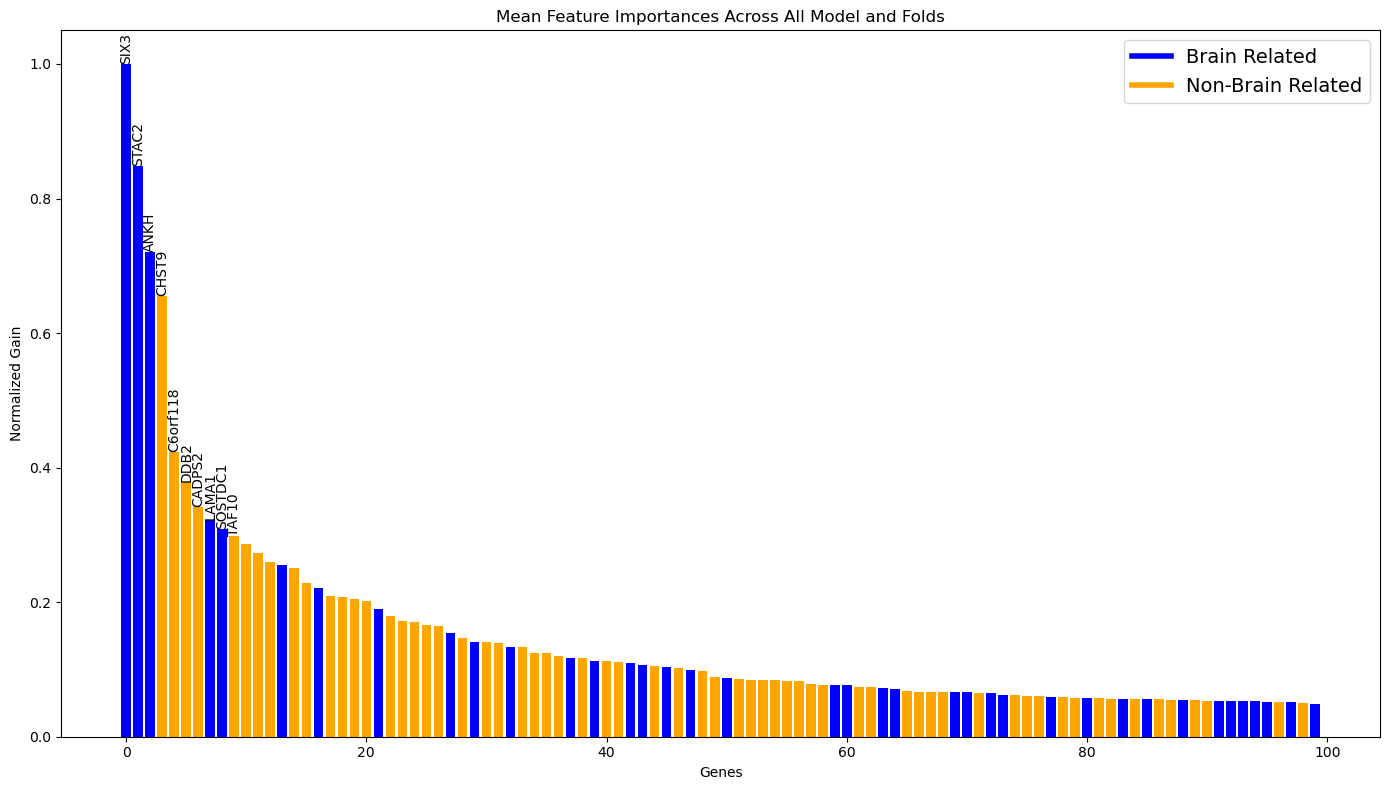

In [46]:

# Perform enrichment analysis using gseapy (Enrichr API)
enrichment_results = gp.enrichr(
    gene_list=gene_list,  # List of gene names
    gene_sets='GO_Biological_Process_2023',  # Gene set database
    organism='Human',  # Specify the organism (human in this case)
    outdir=None,  # Optional output directory for results
)

# Extract the enrichment results
enrichment_df = enrichment_results.results

# Define a comprehensive set of brain-related terms
brain_related_terms = [
    'neuron', 'neurotransmitter', 'brain development', 'synaptic', 'cerebral', 'neurological',
    'glia', 'astrocytes', 'microglia', 'oligodendrocytes', 'signaling', 'action potential',
    'cognitive', 'memory', 'learning', 'brain', 'nervous system', 'calcium', 'binding', 'calcium channel', 'potassium channel',
    'sodium channel', 'ion channel', 'synapse', 'dendrite', 'axon', 'synaptic plasticity', 'long-term potentiation',
    'long-term depression', 'synaptogenesis', 'neurogenesis', 'synaptic vesicle', 'neurotrophin', 'brainstem',
    'cerebral cortex', 'hippocampus', 'amygdala', 'thalamus', 'hypothalamus', 'basal ganglia', 'cerebellum',
    'motor cortex', 'sensory cortex', 'frontal lobe', 'parietal lobe', 'temporal lobe', 'occipital lobe',
    'reticular formation', 'brain signaling', 'neural projection', 'cognitive function', 'cognition', 'behavioral',
    'learning', 'mental', 'psychological', 'electrophysiology', 'synaptic transmission', 'neurotransmission', 
    'development', 'signaling', 'transmission'
]

# Filter for brain-related genes
brain_related_genes = set()

for _, row in enrichment_df.iterrows():
    if any(term in row['Term'].lower() for term in brain_related_terms):
        for gene in row['Genes'].split(';'):
            brain_related_genes.add(gene)

# Create a dictionary mapping gene names to their types
gene_type_dict = {gene: 'brain_related' if gene in brain_related_genes else 'non_brain_related' for gene in gene_list}

# Print the dictionary
print(gene_type_dict)

# Create a color map based on gene type
colors = ['blue' if gene_type_dict.get(gene, 'non_brain_related') == 'brain_related' else 'orange' for gene in df_sorted_500.index]

# Create a bar plot
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(df_sorted_500)), df_sorted_500['Feature Importance'], color=colors)

# Add labels and title
plt.xlabel('Genes')
plt.ylabel('Normalized Gain')
plt.title('Mean Feature Importances Across All Model and Folds')

# Label the top 10 genes
for i in range(10):
    plt.text(i, df_sorted_500['Feature Importance'].iloc[i], df_sorted_500.index[i], ha='center', va='bottom', fontsize=10, rotation=90)

# Create a legend
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Brain Related'),
                    plt.Line2D([0], [0], color='orange', lw=4, label='Non-Brain Related')], fontsize=14)

plt.tight_layout()
plt.show()